# Advance Machine Learning

## PUBG Finish Placement Prediction

### Team Member
#### Palazzi Bruno - 806908
#### Giacomo Villa - 807462

# TO DO


# Attributes
* assists: Number of enemy players this player damaged that were killed by teammates.
* boosts: Number of boost items used.
* damageDealt: Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs: Number of enemy players knocked.
* headshotKills: Number of enemy players killed with headshots.
* heals: Number of healing items used.
* killPlace: Ranking in match of number of enemy players killed.
* killPoints: Kills-based external ranking of player.
* kills: Number of enemy players killed. 
* killStreaks: Max number of enemy players killed in a short amount of time.
* longestKill: Longest distance between player and player killed at time of death.
* matchDuration: Duration of match in seconds.
* matchType: String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches. 
* numGroups: Number of groups we have data for in the match.
* revives: Number of times this player revived teammates.
* rideDistance: Total distance traveled in vehicles measured in meters.
* roadKills: Number of kills while in a vehicle.
* swimDistance: Total distance traveled by swimming measured in meters.
* teamKills: Number of times this player killed a teammate.
* vehicleDestroys: Number of vehicles destroyed.
* walkDistance: Total distance traveled on foot measured in meters.
* weaponsAcquired: Number of weapons picked up.
* winPoints: Win-based external ranking of player. 
* maxPlace: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements. 

# Libraries

In [4]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

import collections

import statistics 

import numpy as np

from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

import keras 
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Function

In [18]:
def load_data():
    fields = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
             'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 
              'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
               'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']
    data = pd.read_csv('../data/dataset.csv', usecols=fields)
    # data = data['matchType' == 'squad-fpp']
    print("START DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def select_typology(data, typology):
    
    if typology == 'solo-fpp':
        del data['DBNOs']
        del data['revives']
        
        
    data = data[data.matchType == typology]
    del data['matchType']
    print("SELECT TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    
    return data

def transform_task(data):
    labels = list()
    scores = data.winPlacePerc
    for score in scores:
        score = round(score, 2)
        if score >= 0 and score <= 0.2:
            labels.append(0)
        elif score >= 0.21 and score <= 0.4:
            labels.append(1)
        elif score >= 0.41 and score <= 0.6:
            labels.append(2)
        elif score >= 0.61 and score <= 0.8:
            labels.append(3)
        elif score >= 0.81 and score <= 1:
            labels.append(4)
        else:
            print("PROBLEMS VALUES: ", score)
            labels.append(-1)
    
    del data['winPlacePerc']
    
    data['label'] = labels
    
    data = data.drop(data[data.label == -1].index)
    
    print("CHANGE TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data


def preprocessing_data(dataset):
    
    data = dataset.values.copy()
    
    x = data[:, 0:-1].astype(np.float32) 
    y = data[:, -1]
    y = np_utils.to_categorical(y, 5)
    
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    
    return x, y

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(15, 15))
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.3, vmin=-1, vmax=1, annot=True)
    
def print_distribution(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["label"].value_counts()
    number = dict(collections.OrderedDict(sorted(number.items())))
    show = list()
    print(number)
    for value in number:
        show.append(number[value])
    print(show)
    ax1.pie(show, explode = (0, 0, 0, 0, 0.2), labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def print_kills_number(kills):
    
    plt.figure(figsize=(15,10))
    
    plt.title("Kills")
    plt.xlabel("# kills")
    plt.ylabel("times")
    
    kills_number = [0]*10
    names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
    
    for kill in kills:
        if kill >= 10:
            kills_number[9] += 1
        else:
            kills_number[kill] += 1
            
    print(kills_number)
    plt.bar(np.arange(10), height = kills_number)
    plt.show()

def print_sns_hist(value, name):
    plt.figure(figsize=(15, 10))
    value.name = name
    sns.distplot(value)
    
def print_sns_join_plot(x_value, y_value, dataset):
    sns.jointplot(x_value, y_value, dataset, ratio=3, height=15)
    plt.show()

def print_sns_pairplot(dataset, based):
    plt.figure(figsize=(60, 60))
    sns.set(font_scale=5)
    g = sns.pairplot(dataset, vars=["killPlace", "weaponsAcquired", "kills", "damageDealt", "walkDistance"],
                     hue="label", markers=["o", "x"], height = 10)
    new_labels = ['Low', 'High']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    plt.show()
    sns.set()
    
def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)
    
    
def define_net(first_layer, second_layer, third_layer, n_layers, opt, input_size):
    model = Sequential()
    model.add(Dense(first_layer, input_shape = (input_size,), activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    
    if n_layers == 2:
        model.add(Dense(second_layer, activation='relu'))
        model.add(Dropout(0.4, noise_shape=None, seed=None))
        
    elif n_layers == 3:
        model.add(Dense(second_layer, activation='relu'))
        model.add(Dropout(0.4, noise_shape=None, seed=None))
        model.add(Dense(third_layer, activation='relu'))
        model.add(Dropout(0.4, noise_shape=None, seed=None))
        
    model.add(Dense(5))
    model.add(Activation('softmax'))
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])  
    return model

# optimizers:
# 0: SGD, 1: RMSprop, 2: Adagrad, 3: Adadelta
    
def compute_accuracy(conf_lr, conf_mom, conf_rho, conf_n_layers, conf_fl, conf_sl, conf_tl, conf_opt):
    
    kfold = StratifiedKFold(n_splits = 3, shuffle=False)
    
    if conf_opt == 0:
        opt = optimizers.SGD(conf_lr, conf_mom)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "SGD"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY MOMENTUM:", round(conf_mom, 5)))
    elif conf_opt == 1:
        opt = optimizers.RMSprop(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "RMSprop"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
    elif conf_opt == 2:
        opt = optimizers.Adagrad(conf_lr)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adagrad"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
    else:
        opt = optimizers.Adadelta(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adadelta"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))  
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
        
    print("{:<21}{:>5}".format("TRY NUMBER LAYERS:", int(conf_n_layers)))
    if int(conf_n_layers) == 1:
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
    elif int(conf_n_layers) == 2:
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
        print("{:<21}{:>5}".format("TRY SECOND LAYER: ", int(conf_sl)))
    elif int(conf_n_layers) == 3:
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
        print("{:<21}{:>5}".format("TRY SECOND LAYER: ", int(conf_sl)))
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_tl)))
  
    print("")

    
    x_train, y_train = preprocessing_data(typology_data)
    
    es = EarlyStopping(monitor='val_accuracy', patience = 5, verbose = 0, restore_best_weights = True)
    
    cvscores = []
    
    fold = 0
    
    label_noOneHot = typology_data.values.copy()[:, -1]
    
    prediction = list()
    labels_real = list()
    prediction_array = list()
    labels_real_array = list()
    global run
    print("{:<21}{:>5}".format("RUN NUMBER: ", run))
    run += 1
    
    for train, test in kfold.split(x_train, label_noOneHot):
        
        print("{:<21}{:>5}".format("FOLD NUMBER: ", fold + 1))
        
        x_test_real, x_val, y_test_real, y_val = train_test_split(x_train[test], y_train[test],
                                                                  test_size = 0.2)
        
        model = define_net(int(conf_fl), int(conf_sl), int(conf_tl), conf_n_layers, opt, 20)
        
        model.fit(x_train[train], y_train[train], epochs=200, batch_size=256, verbose = 0, validation_data=(x_val, y_val), 
                                    callbacks = [es])
        
        scores_accuracy = model.evaluate(x_test_real, y_test_real, verbose = 0)
        labels_predict = model.predict_classes(x_test_real)
        
        for predict in labels_predict:
            prediction.append(predict)
        
        for label in y_test_real:    
            labels_real.append(np.where(label == np.amax(label))[0][0])
        
        prediction_array = np.array(prediction)
        labels_real_array = np.array(labels_real)
        
        plotConfusionMatrix(labels_real_array, prediction_array, ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
                        False, "Confusion Matrix fold: " + str(fold + 1))
        print("{:<21}{:>5}".format("ACCURACY FOLD OBTAIN: ", scores_accuracy[1]))
        cvscores.append(scores_accuracy[1])
        
        
        print("{:<21}{:>5}".format("PRECISION LOW: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['0']['precision']))
        print("{:<21}{:>5}".format("PRECISION MEDIUM-LOW: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['1']['precision']))
        print("{:<21}{:>5}".format("PRECISION MEDIUM: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['2']['precision']))
        print("{:<21}{:>5}".format("PRECISION MEDIUM-HIGH: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['3']['precision']))
        print("{:<21}{:>5}".format("PRECISION HIGH: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['4']['precision']))
        print("{:<21}{:>5}".format("RECALL LOW: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['0']['recall']))
        print("{:<21}{:>5}".format("RECALL MEDIUM-LOW: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['1']['recall']))
        print("{:<21}{:>5}".format("RECALL MEDIUM: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['2']['recall']))
        print("{:<21}{:>5}".format("RECALL MEDIUM-HIGH: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['3']['recall']))
        print("{:<21}{:>5}".format("RECALL HIGH: ", classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['4']['recall']))
        
        prediction.clear()
        labels_real.clear()
        
        fold += 1
        
    if len(best_seen) == 0:
        best_seen.append(np.mean(cvscores))
    else:
        if np.mean(cvscores) > max(best_seen):
            best_seen.append(np.mean(cvscores))
        else:
            best_seen.append(best_seen[-1])
    
    print("{:<21}{:>5}".format("ACCURACY OBTAIN: ", np.mean(cvscores)))
    return (np.mean(cvscores))

# Loading Data

In [7]:
data = load_data()
changed_task_data = transform_task(data)
typology_data = select_typology(changed_task_data, 'solo-fpp')

START DATASET
   assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0        0       0         0.00      0              0      0         60   
1        0       0        91.47      0              0      0         57   
2        1       0        68.00      0              0      0         47   
3        0       0        32.90      0              0      0         75   
4        0       0       100.00      0              0      0         45   

   killPoints  kills  killStreaks  ...  revives  rideDistance roadKills  \
0        1241      0            0  ...        0        0.0000         0   
1           0      0            0  ...        0        0.0045         0   
2           0      0            0  ...        0        0.0000         0   
3           0      0            0  ...        0        0.0000         0   
4           0      1            1  ...        0        0.0000         0   

   swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
0     

# Data Analysis

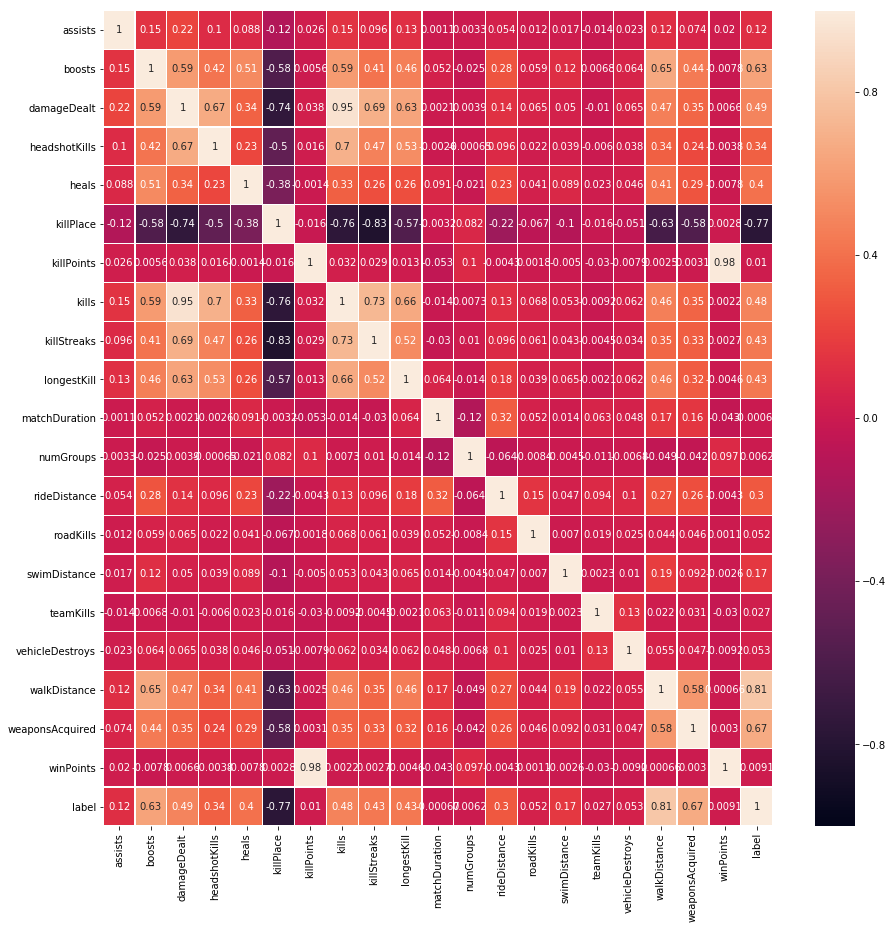

In [8]:
print_correlation_matrix(typology_data)

{0: 117553, 1: 106768, 2: 105774, 3: 101822, 4: 104844}
[117553, 106768, 105774, 101822, 104844]


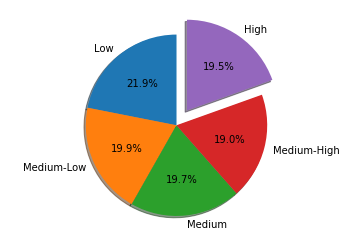

In [9]:
print_distribution(typology_data)

In [ ]:
print("NUMBER OF ROW: ", len(typology_data))

### Kills 

In [ ]:
avg_kill = statistics.mean(typology_data.kills)
print("{:<25}{:>5}".format("AVERAGE KILLS IN A MATCH:", round(avg_kill, 3)))

In [ ]:
print_kills_number(typology_data.kills)

### Walk

In [ ]:
print("{:<20}{:>6}".format("PLAYERS DIED IMMEDIATELY:",len(typology_data[typology_data.walkDistance == 0])))

In [ ]:
print_sns_hist(typology_data.walkDistance, "Walking Distance")

### Damage

In [ ]:
avg_damage = statistics.mean(typology_data.damageDealt)
print("{:<25}{:>5}".format("AVERAGE DAMAGE IN A MATCH: ", round(avg_damage, 3)))

In [ ]:
print_sns_hist(typology_data.damageDealt, "Damage inflicted")

### Walking x Damage

In [ ]:
print_sns_join_plot("walkDistance", "damageDealt", typology_data)

### Walking x Kills

In [ ]:
print_sns_join_plot("walkDistance", "kills", typology_data)

### Damage x Kills

In [ ]:
print_sns_join_plot("damageDealt", "kills", typology_data)

### Walking x Swimming

In [ ]:
print_sns_join_plot("walkDistance", "swimDistance", typology_data)

### Weapons pick up x Kills 

In [ ]:
print_sns_join_plot("weaponsAcquired", "kills", typology_data)

### Boosts x Kills 

In [ ]:
print_sns_join_plot("boosts", "kills", typology_data)

### High vs Low class study

In [ ]:
high = typology_data[typology_data.label == 4]
low = typology_data[typology_data.label == 0]
match_dataset = pd.concat([high[0:1000], low[0:1000]])
print_sns_pairplot(match_dataset, 'label')

In [ ]:
avg_kill = statistics.mean(high.kills)
print("{:<32}{:>5}".format("AVERAGE KILLS FOR PRO PLAYERS:", round(avg_kill, 3)))
print("{:<32}{:>5}".format("MAX KILLS BY PRO PLAYES:", max(high.kills)))
print("{:<32}{:>5}".format("MIN KILLS BY PRO PLAYES:", min(high.kills)))

In [ ]:
print_kills_number(high.kills)

In [ ]:
print_sns_hist(high.walkDistance, "Walking Distance")

In [ ]:
print_sns_hist(high.damageDealt, "Damage inflicted")

# Optimization

In [12]:
param = {'conf_lr': ('cont', [0.01,0.1]), 'conf_mom': ('cont', [0.1, 0.9]), 'conf_rho': ('cont', [0.1, 0.95]),
         'conf_n_layers': ('int', [1, 3]), 'conf_fl': ('int', [150, 300]), 'conf_sl': ('int', [100, 250]),
         'conf_tl': ('int', [50, 100]), 'conf_opt': ('int', [0, 3])}
sur_model = RandomForest()
acq = Acquisition(mode="ExpectedImprovement")

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.05026
TRY MOMENTUM:        0.81078
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       196

RUN NUMBER:              1
FOLD NUMBER:             1


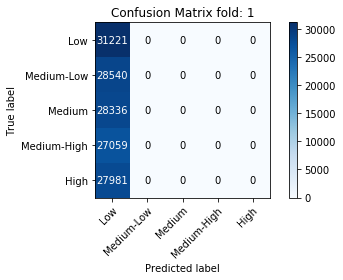

ACCURACY FOLD OBTAIN: 0.21811971068382263
PRECISION LOW:       0.21811970350084184


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
FOLD NUMBER:             2


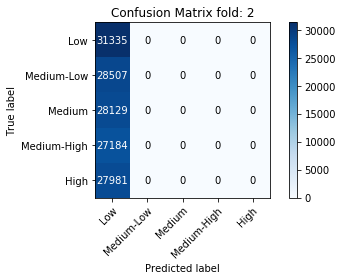

ACCURACY FOLD OBTAIN: 0.21891766786575317
PRECISION LOW:       0.21891767270288398


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
FOLD NUMBER:             3


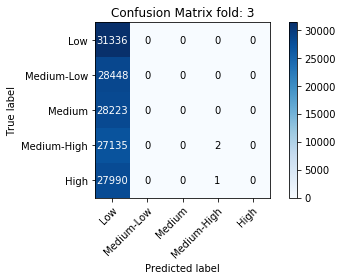

ACCURACY FOLD OBTAIN: 0.21894016861915588
PRECISION LOW:       0.21893077718469664


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH: 0.6666666666666666
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:  7.370011423517707e-05
RECALL HIGH:           0.0
ACCURACY OBTAIN:     0.21865918238957724
TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.02916
TRY MOMENTUM:        0.76734
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       182

RUN NUMBER:              2
FOLD NUMBER:             1


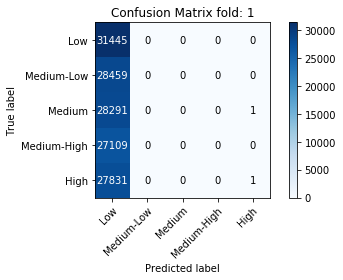

ACCURACY FOLD OBTAIN: 0.21969161927700043
PRECISION LOW:       0.21968770740908933


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.5
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         3.592986490370796e-05
FOLD NUMBER:             2


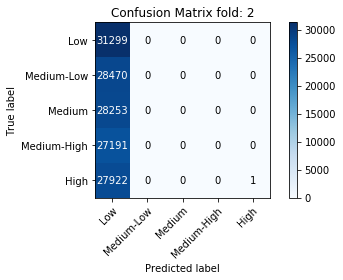

ACCURACY FOLD OBTAIN: 0.21867315471172333
PRECISION LOW:       0.21866769134034303


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        1.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         3.581277083407943e-05
FOLD NUMBER:             3


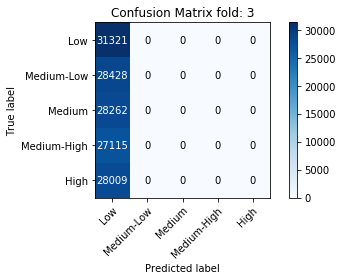

ACCURACY FOLD OBTAIN: 0.21882139146327972
PRECISION LOW:       0.21882139239179796


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
ACCURACY OBTAIN:     0.21906205515066782
TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05021
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       291
TRY SECOND LAYER:      196

RUN NUMBER:              3
FOLD NUMBER:             1


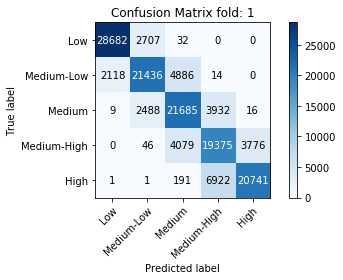

ACCURACY FOLD OBTAIN: 0.7819012403488159
PRECISION LOW:       0.9309315157416423
PRECISION MEDIUM-LOW: 0.8035085088837244
PRECISION MEDIUM:    0.7023936773232274
PRECISION MEDIUM-HIGH: 0.6406441159937837
PRECISION HIGH:      0.8454326825092732
RECALL LOW:          0.9128289997135673
RECALL MEDIUM-LOW:   0.7533562943698602
RECALL MEDIUM:       0.7708851759687166
RECALL MEDIUM-HIGH:  0.7103314268954393
RECALL HIGH:         0.7445792647903504
FOLD NUMBER:             2


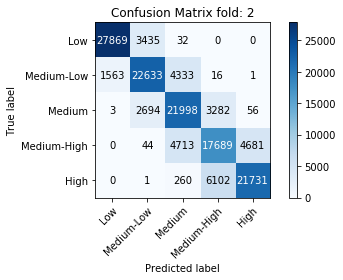

ACCURACY FOLD OBTAIN: 0.781913697719574
PRECISION LOW:       0.9467980295566503
PRECISION MEDIUM-LOW: 0.7856770923733815
PRECISION MEDIUM:    0.702004084758744
PRECISION MEDIUM-HIGH: 0.6529956809036879
PRECISION HIGH:      0.8209981487778155
RECALL LOW:          0.8893604799591525
RECALL MEDIUM-LOW:   0.7928606459749177
RECALL MEDIUM:       0.7847180109157065
RECALL MEDIUM-HIGH:  0.6520809525564936
RECALL HIGH:         0.7735103580835766
FOLD NUMBER:             3


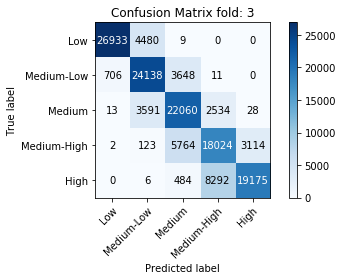

ACCURACY FOLD OBTAIN: 0.7708107829093933
PRECISION LOW:       0.9739278223765098
PRECISION MEDIUM-LOW: 0.7464283505473437
PRECISION MEDIUM:    0.6901298295010168
PRECISION MEDIUM-HIGH: 0.6245105852188074
PRECISION HIGH:      0.8592104673567236
RECALL LOW:          0.8571383107376997
RECALL MEDIUM-LOW:   0.8468582254499526
RECALL MEDIUM:       0.7815489265216468
RECALL MEDIUM-HIGH:  0.6668886668886669
RECALL HIGH:         0.6858747362020245
ACCURACY OBTAIN:     0.7782085736592611
TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.06914
TRY RHO:             0.42946
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       198
TRY SECOND LAYER:      153

RUN NUMBER:              4
FOLD NUMBER:             1


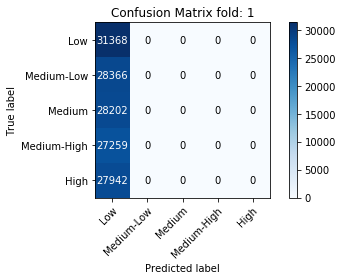

ACCURACY FOLD OBTAIN: 0.2191466987133026
PRECISION LOW:       0.21914669163109468


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
FOLD NUMBER:             2


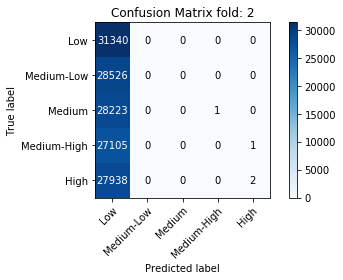

ACCURACY FOLD OBTAIN: 0.21896657347679138
PRECISION LOW:       0.21895872341614733


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:      0.6666666666666666
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         7.158196134574088e-05
FOLD NUMBER:             3


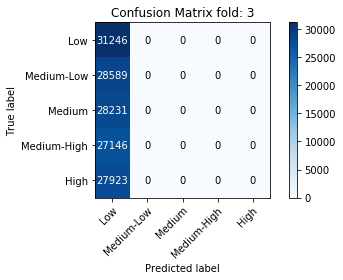

ACCURACY FOLD OBTAIN: 0.21829740703105927
PRECISION LOW:       0.21829741153456528


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
ACCURACY OBTAIN:     0.21880355974038443
TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.09638
TRY MOMENTUM:        0.39957
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       253
TRY SECOND LAYER:      100

RUN NUMBER:              5
FOLD NUMBER:             1


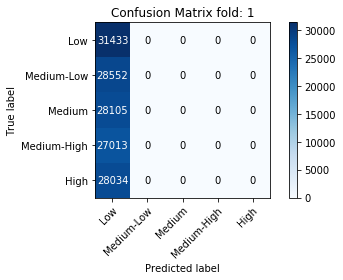

ACCURACY FOLD OBTAIN: 0.21960079669952393
PRECISION LOW:       0.21960080202882554


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
FOLD NUMBER:             2


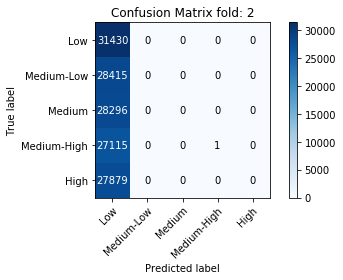

ACCURACY FOLD OBTAIN: 0.21958836913108826
PRECISION LOW:       0.21958291123764279


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   1.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:  3.687859566307715e-05
RECALL HIGH:           0.0
FOLD NUMBER:             3


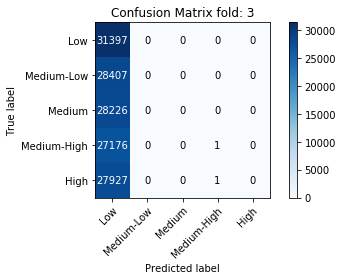

ACCURACY FOLD OBTAIN: 0.2193593531847
PRECISION LOW:       0.21935542467495267


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.5
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:  3.679581999484859e-05
RECALL HIGH:           0.0
ACCURACY OBTAIN:     0.21951617300510406


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
bo = GPGO(sur_model, acq, compute_accuracy, param, n_jobs=1)
best_seen = list()
run = 1
bo._firstRun(5)

TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.02192
TRY RHO:             0.42041
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       204
TRY SECOND LAYER:      197

RUN NUMBER:              6
FOLD NUMBER:             1


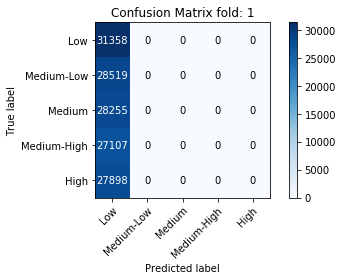

ACCURACY FOLD OBTAIN: 0.21907682716846466
PRECISION LOW:       0.21907682849298224


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
FOLD NUMBER:             2


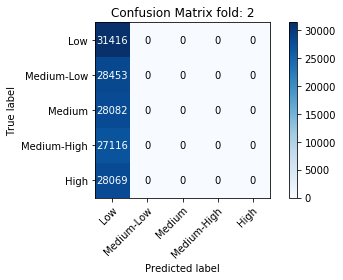

ACCURACY FOLD OBTAIN: 0.21948356926441193
PRECISION LOW:       0.21948356807511737


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
FOLD NUMBER:             3


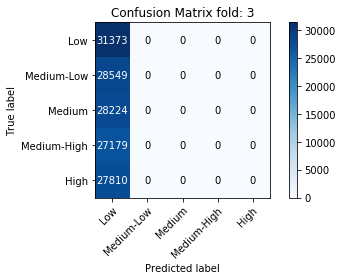

ACCURACY FOLD OBTAIN: 0.21918468177318573
PRECISION LOW:       0.21918468578614594


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:           0.0
ACCURACY OBTAIN:     0.21924835940202078
init   	 [2.19215502e-02 7.37764633e-01 4.20414447e-01 2.00000000e+00
 2.04000000e+02 1.97000000e+02 6.80000000e+01 1.00000000e+00]. 	  0.21924835940202078 	 0.21924835940202078


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01794
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       181

RUN NUMBER:              7
FOLD NUMBER:             1


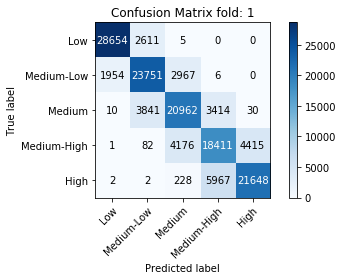

ACCURACY FOLD OBTAIN: 0.7924296259880066
PRECISION LOW:       0.9357630384376735
PRECISION MEDIUM-LOW: 0.7841978406577079
PRECISION MEDIUM:    0.7397134589597008
PRECISION MEDIUM-HIGH: 0.6623138355277358
PRECISION HIGH:      0.8296477982600697
RECALL LOW:          0.9163415414134953
RECALL MEDIUM-LOW:   0.828195829555757
RECALL MEDIUM:       0.7418338818699791
RECALL MEDIUM-HIGH:  0.6797489385268599
RECALL HIGH:         0.7773907422702625
FOLD NUMBER:             2


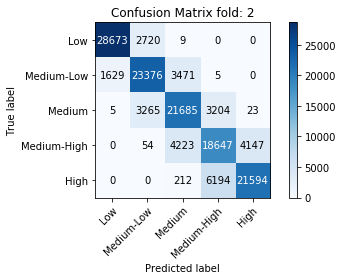

ACCURACY FOLD OBTAIN: 0.7962706685066223
PRECISION LOW:       0.9460850628567657
PRECISION MEDIUM-LOW: 0.7946965833758287
PRECISION MEDIUM:    0.7326013513513514
PRECISION MEDIUM-HIGH: 0.664777183600713
PRECISION HIGH:      0.8381462505822077
RECALL LOW:          0.9130947073434813
RECALL MEDIUM-LOW:   0.8207576981145325
RECALL MEDIUM:       0.769462777659499
RECALL MEDIUM-HIGH:  0.6888182926378782
RECALL HIGH:         0.7712142857142857
FOLD NUMBER:             3


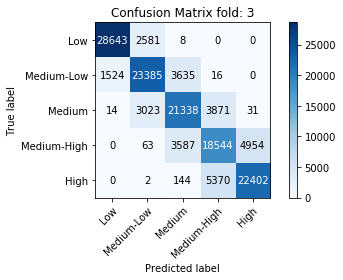

ACCURACY FOLD OBTAIN: 0.7986306548118591
PRECISION LOW:       0.9490407872502568
PRECISION MEDIUM-LOW: 0.80488056721966
PRECISION MEDIUM:    0.7431735859570912
PRECISION MEDIUM-HIGH: 0.6670263659580591
PRECISION HIGH:      0.817979333260306
RECALL LOW:          0.9171042520491803
RECALL MEDIUM-LOW:   0.8188025210084033
RECALL MEDIUM:       0.7546062170668741
RECALL MEDIUM-HIGH:  0.6830705761013702
RECALL HIGH:         0.802421376889462
ACCURACY OBTAIN:     0.7957769831021627
1      	 [1.79385735e-02 1.81117826e-01 3.71657134e-01 1.00000000e+00
 1.81000000e+02 1.18000000e+02 7.80000000e+01 2.00000000e+00]. 	  0.7957769831021627 	 0.7957769831021627


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01084
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       284

RUN NUMBER:              8
FOLD NUMBER:             1


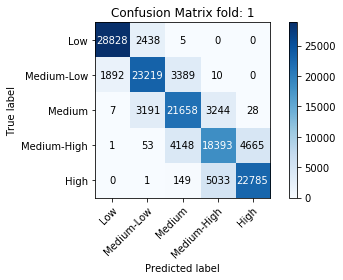

ACCURACY FOLD OBTAIN: 0.8026086688041687
PRECISION LOW:       0.9381671439729237
PRECISION MEDIUM-LOW: 0.8033700089959173
PRECISION MEDIUM:    0.7379467784251593
PRECISION MEDIUM-HIGH: 0.6893928035982009
PRECISION HIGH:      0.8292088216027368
RECALL LOW:          0.9218764989926769
RECALL MEDIUM-LOW:   0.8144159943879341
RECALL MEDIUM:       0.7699800910125142
RECALL MEDIUM-HIGH:  0.6747248716067498
RECALL HIGH:         0.8146810640732265
FOLD NUMBER:             2


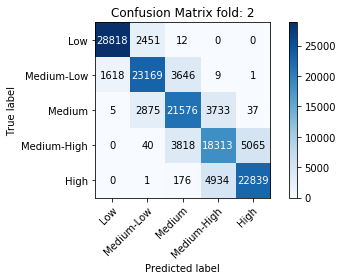

ACCURACY FOLD OBTAIN: 0.8014405965805054
PRECISION LOW:       0.9466837488912979
PRECISION MEDIUM-LOW: 0.8119217830109335
PRECISION MEDIUM:    0.7381962501710688
PRECISION MEDIUM-HIGH: 0.6785356997295194
PRECISION HIGH:      0.8173716985183594
RECALL LOW:          0.9212621079888751
RECALL MEDIUM-LOW:   0.8145765214639806
RECALL MEDIUM:       0.7644016155317792
RECALL MEDIUM-HIGH:  0.6723821412835952
RECALL HIGH:         0.8171377459749553
FOLD NUMBER:             3


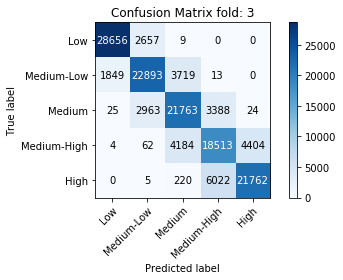

ACCURACY FOLD OBTAIN: 0.7935655117034912
PRECISION LOW:       0.9384947926901159
PRECISION MEDIUM-LOW: 0.8010146955913227
PRECISION MEDIUM:    0.7279812677705302
PRECISION MEDIUM-HIGH: 0.6626932989690721
PRECISION HIGH:      0.8309278350515464
RECALL LOW:          0.9148841070174318
RECALL MEDIUM-LOW:   0.8039966285031959
RECALL MEDIUM:       0.7727514824415013
RECALL MEDIUM-HIGH:  0.6814517613280818
RECALL HIGH:         0.7769645471098575
ACCURACY OBTAIN:     0.7992049256960551
2      	 [1.08373606e-02 5.19181248e-01 1.23494249e-01 1.00000000e+00
 2.84000000e+02 2.27000000e+02 8.70000000e+01 2.00000000e+00]. 	  0.7992049256960551 	 0.7992049256960551


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.05811
TRY MOMENTUM:        0.23211
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       184

RUN NUMBER:              9
FOLD NUMBER:             1


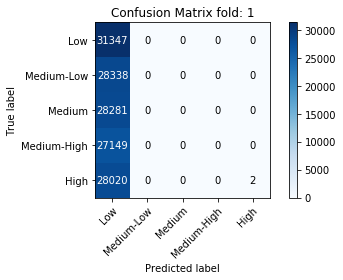

ACCURACY FOLD OBTAIN: 0.21901394426822662
PRECISION LOW:       0.21900303908897195


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        1.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         7.137249304118193e-05
FOLD NUMBER:             2


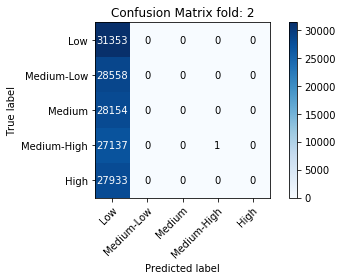

ACCURACY FOLD OBTAIN: 0.21905040740966797
PRECISION LOW:       0.21904495755755057


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   1.0
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:  3.684869924091679e-05
RECALL HIGH:           0.0
FOLD NUMBER:             3


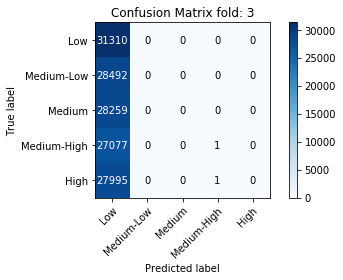

ACCURACY FOLD OBTAIN: 0.21875153481960297
PRECISION LOW:       0.2187475983875137


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.5
PRECISION HIGH:        0.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:  3.6930349361104953e-05
RECALL HIGH:           0.0
ACCURACY OBTAIN:     0.21893862883249918
3      	 [5.81134914e-02 2.32114378e-01 1.18960137e-01 1.00000000e+00
 1.84000000e+02 2.16000000e+02 8.10000000e+01 0.00000000e+00]. 	  0.21893862883249918 	 0.7992049256960551


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01634
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       298

RUN NUMBER:             10
FOLD NUMBER:             1


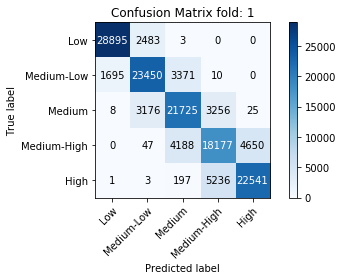

ACCURACY FOLD OBTAIN: 0.8019449710845947
PRECISION LOW:       0.9443119056178306
PRECISION MEDIUM-LOW: 0.8042113927089406
PRECISION MEDIUM:    0.7368403201736535
PRECISION MEDIUM-HIGH: 0.6813223883953672
PRECISION HIGH:      0.8282260435038212
RECALL LOW:          0.9207800898632931
RECALL MEDIUM-LOW:   0.8220570707424806
RECALL MEDIUM:       0.7706633557999291
RECALL MEDIUM-HIGH:  0.6716798462789151
RECALL HIGH:         0.8056687397240689
FOLD NUMBER:             2


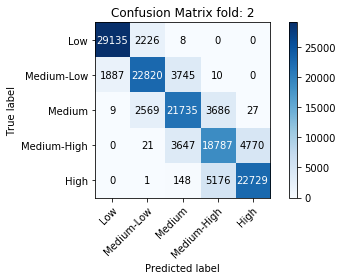

ACCURACY FOLD OBTAIN: 0.8048709034919739
PRECISION LOW:       0.9388998098675518
PRECISION MEDIUM-LOW: 0.8257046712740167
PRECISION MEDIUM:    0.742239524638869
PRECISION MEDIUM-HIGH: 0.6792364149101559
PRECISION HIGH:      0.8257284022378841
RECALL LOW:          0.9287831935987758
RECALL MEDIUM-LOW:   0.8017707820954255
RECALL MEDIUM:       0.7755298651252408
RECALL MEDIUM-HIGH:  0.6900642791551882
RECALL HIGH:         0.8101874955443074
FOLD NUMBER:             3


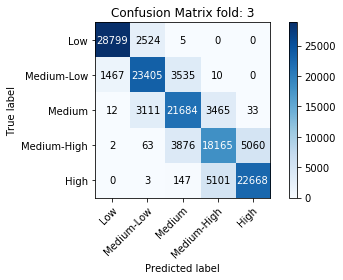

ACCURACY FOLD OBTAIN: 0.8014881014823914
PRECISION LOW:       0.9510898282694848
PRECISION MEDIUM-LOW: 0.8041297327011613
PRECISION MEDIUM:    0.7414093753205457
PRECISION MEDIUM-HIGH: 0.6792939680640215
PRECISION HIGH:      0.8165411908792911
RECALL LOW:          0.919273493360572
RECALL MEDIUM-LOW:   0.8236267023260724
RECALL MEDIUM:       0.7660837307896131
RECALL MEDIUM-HIGH:  0.6686667157476257
RECALL HIGH:         0.8119201977148178
ACCURACY OBTAIN:     0.8027679920196533
4      	 [1.63364505e-02 5.20965923e-01 4.96731399e-01 1.00000000e+00
 2.98000000e+02 1.28000000e+02 9.30000000e+01 2.00000000e+00]. 	  0.8027679920196533 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01167
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       202

RUN NUMBER:             11
FOLD NUMBER:             1


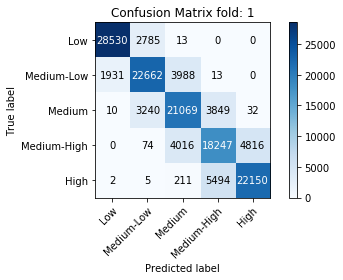

ACCURACY FOLD OBTAIN: 0.7870641350746155
PRECISION LOW:       0.9362386374823615
PRECISION MEDIUM-LOW: 0.7878050476256692
PRECISION MEDIUM:    0.7191521316175717
PRECISION MEDIUM-HIGH: 0.6610513349998188
PRECISION HIGH:      0.8204311430476332
RECALL LOW:          0.9106869254341164
RECALL MEDIUM-LOW:   0.792543890326642
RECALL MEDIUM:       0.7471276595744681
RECALL MEDIUM-HIGH:  0.6720067764151291
RECALL HIGH:         0.794989591558395
FOLD NUMBER:             2


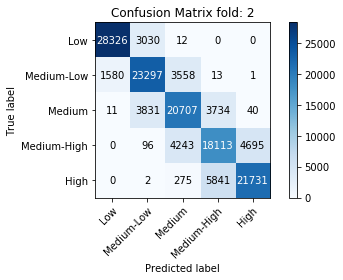

ACCURACY FOLD OBTAIN: 0.7836882472038269
PRECISION LOW:       0.946819534044189
PRECISION MEDIUM-LOW: 0.7699960338445268
PRECISION MEDIUM:    0.7191179024136135
PRECISION MEDIUM-HIGH: 0.6538753113606007
PRECISION HIGH:      0.8210601881588393
RECALL LOW:          0.9030221882172915
RECALL MEDIUM-LOW:   0.8189040036556645
RECALL MEDIUM:       0.731101931292589
RECALL MEDIUM-HIGH:  0.6672192139094559
RECALL HIGH:         0.780315271643506
FOLD NUMBER:             3


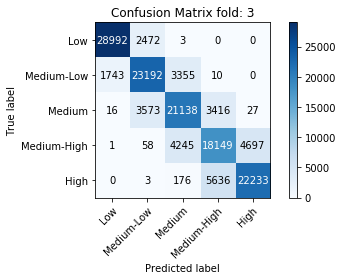

ACCURACY FOLD OBTAIN: 0.7943829298019409
PRECISION LOW:       0.9427679500520292
PRECISION MEDIUM-LOW: 0.7915898696156735
PRECISION MEDIUM:    0.7309886917730055
PRECISION MEDIUM-HIGH: 0.6669729153651097
PRECISION HIGH:      0.8247579478428608
RECALL LOW:          0.9213461721803794
RECALL MEDIUM-LOW:   0.8195053003533569
RECALL MEDIUM:       0.7503727369542066
RECALL MEDIUM-HIGH:  0.6684714548802947
RECALL HIGH:         0.7926768397033657
ACCURACY OBTAIN:     0.7883784373601278
5      	 [1.16683766e-02 5.05748468e-01 5.73178669e-01 1.00000000e+00
 2.02000000e+02 2.14000000e+02 9.90000000e+01 2.00000000e+00]. 	  0.7883784373601278 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.0993
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       263

RUN NUMBER:             12
FOLD NUMBER:             1


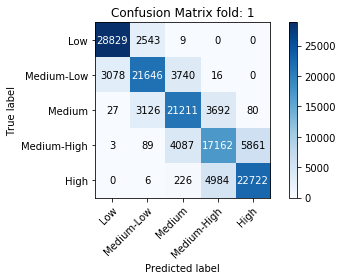

ACCURACY FOLD OBTAIN: 0.7794630527496338
PRECISION LOW:       0.9026834079594201
PRECISION MEDIUM-LOW: 0.7897117840204305
PRECISION MEDIUM:    0.7245926280189936
PRECISION MEDIUM-HIGH: 0.6638044403187128
PRECISION HIGH:      0.7927293025852143
RECALL LOW:          0.9186769064083362
RECALL MEDIUM-LOW:   0.7600421348314607
RECALL MEDIUM:       0.7538740403753199
RECALL MEDIUM-HIGH:  0.6309094919491214
RECALL HIGH:         0.813300880521154
FOLD NUMBER:             2


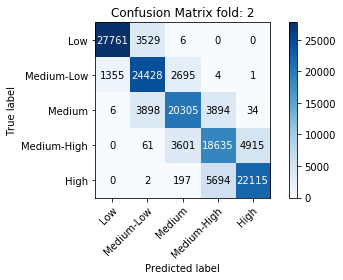

ACCURACY FOLD OBTAIN: 0.7911636233329773
PRECISION LOW:       0.9532655724194767
PRECISION MEDIUM-LOW: 0.7653361739457359
PRECISION MEDIUM:    0.7575361886285629
PRECISION MEDIUM-HIGH: 0.6601835122400539
PRECISION HIGH:      0.817106964714576
RECALL LOW:          0.8870462678936605
RECALL MEDIUM-LOW:   0.8576343784011515
RECALL MEDIUM:       0.7216476525571311
RECALL MEDIUM-HIGH:  0.6848081728649126
RECALL HIGH:         0.7895958297629249
FOLD NUMBER:             3


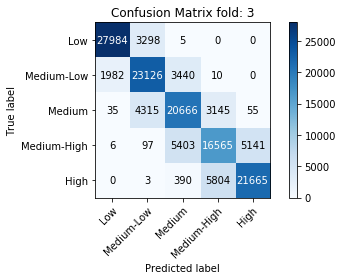

ACCURACY FOLD OBTAIN: 0.7685471773147583
PRECISION LOW:       0.9325823974405972
PRECISION MEDIUM-LOW: 0.7498946139628393
PRECISION MEDIUM:    0.6910781166399144
PRECISION MEDIUM-HIGH: 0.6489970224102806
PRECISION HIGH:      0.8065596962138416
RECALL LOW:          0.8944289960686547
RECALL MEDIUM-LOW:   0.8097906015827439
RECALL MEDIUM:       0.7324213212361781
RECALL MEDIUM-HIGH:  0.6087387917095399
RECALL HIGH:         0.7775823702533917
ACCURACY OBTAIN:     0.7797246177991232
6      	 [9.92971770e-02 8.00859104e-01 6.57073067e-01 1.00000000e+00
 2.63000000e+02 1.89000000e+02 9.00000000e+01 2.00000000e+00]. 	  0.7797246177991232 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01811
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       296

RUN NUMBER:             13
FOLD NUMBER:             1


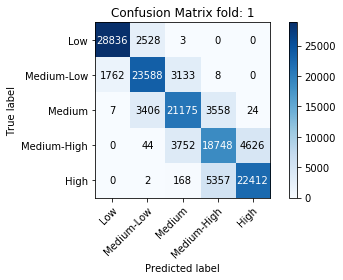

ACCURACY FOLD OBTAIN: 0.8017423748970032
PRECISION LOW:       0.9421989870936122
PRECISION MEDIUM-LOW: 0.797754329004329
PRECISION MEDIUM:    0.7500619885940987
PRECISION MEDIUM-HIGH: 0.6775324346789057
PRECISION HIGH:      0.8281723449855887
RECALL LOW:          0.9193101029744636
RECALL MEDIUM-LOW:   0.8279105682496227
RECALL MEDIUM:       0.7516861909833156
RECALL MEDIUM-HIGH:  0.6900257637099743
RECALL HIGH:         0.8021761695121514
FOLD NUMBER:             2


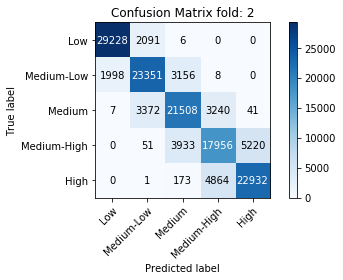

ACCURACY FOLD OBTAIN: 0.8032570481300354
PRECISION LOW:       0.9358050779624115
PRECISION MEDIUM-LOW: 0.8089447793251576
PRECISION MEDIUM:    0.7474284125660272
PRECISION MEDIUM-HIGH: 0.6888138714132269
PRECISION HIGH:      0.8133933955237116
RECALL LOW:          0.9330566640063847
RECALL MEDIUM-LOW:   0.8189597727352436
RECALL MEDIUM:       0.7635614882135757
RECALL MEDIUM-HIGH:  0.661119293078056
RECALL HIGH:         0.819878441186986
FOLD NUMBER:             3


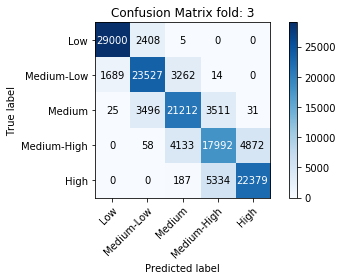

ACCURACY FOLD OBTAIN: 0.7972193956375122
PRECISION LOW:       0.9441948297193462
PRECISION MEDIUM-LOW: 0.7978229170199057
PRECISION MEDIUM:    0.7365533525469634
PRECISION MEDIUM-HIGH: 0.6700681538862612
PRECISION HIGH:      0.8202844366248808
RECALL LOW:          0.9231846687677077
RECALL MEDIUM-LOW:   0.8257405587533343
RECALL MEDIUM:       0.7502033598585323
RECALL MEDIUM-HIGH:  0.6650157087414525
RECALL HIGH:         0.8021146953405018
ACCURACY OBTAIN:     0.800739606221517
7      	 [1.81079062e-02 5.47249609e-01 3.30298972e-01 1.00000000e+00
 2.96000000e+02 2.47000000e+02 8.00000000e+01 2.00000000e+00]. 	  0.800739606221517 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05547
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       176

RUN NUMBER:             14
FOLD NUMBER:             1


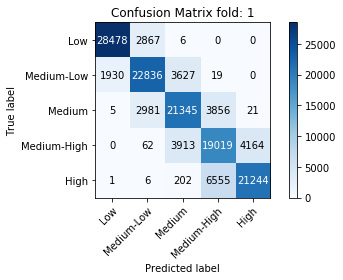

ACCURACY FOLD OBTAIN: 0.7889085412025452
PRECISION LOW:       0.936345104228316
PRECISION MEDIUM-LOW: 0.7942404006677797
PRECISION MEDIUM:    0.7336816416320077
PRECISION MEDIUM-HIGH: 0.6458283812693131
PRECISION HIGH:      0.8354241220653584
RECALL LOW:          0.9083601798985679
RECALL MEDIUM-LOW:   0.8037448965225961
RECALL MEDIUM:       0.7567002268859898
RECALL MEDIUM-HIGH:  0.7003093011267398
RECALL HIGH:         0.7584975721222508
FOLD NUMBER:             2


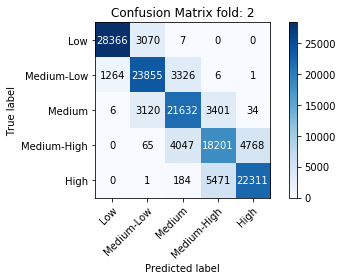

ACCURACY FOLD OBTAIN: 0.7989953756332397
PRECISION LOW:       0.9571467134566068
PRECISION MEDIUM-LOW: 0.7922353957025672
PRECISION MEDIUM:    0.7409234141663241
PRECISION MEDIUM-HIGH: 0.6721444661915137
PRECISION HIGH:      0.8228590396105333
RECALL LOW:          0.9021403810069014
RECALL MEDIUM-LOW:   0.8384296358779699
RECALL MEDIUM:       0.7672826588160182
RECALL MEDIUM-HIGH:  0.6720948266312174
RECALL HIGH:         0.7977616476561662
FOLD NUMBER:             3


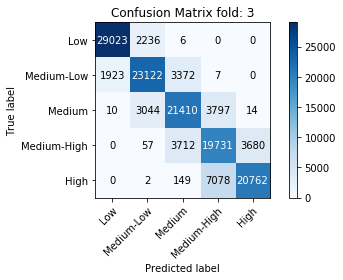

ACCURACY FOLD OBTAIN: 0.7967862486839294
PRECISION LOW:       0.9375565318516604
PRECISION MEDIUM-LOW: 0.8124099645128421
PRECISION MEDIUM:    0.7473210234214108
PRECISION MEDIUM-HIGH: 0.6445301015908275
PRECISION HIGH:      0.8489532221131828
RECALL LOW:          0.928290420598113
RECALL MEDIUM-LOW:   0.8134674922600619
RECALL MEDIUM:       0.7572060123784262
RECALL MEDIUM-HIGH:  0.7259381898454746
RECALL HIGH:         0.7417384159194027
ACCURACY OBTAIN:     0.7948967218399048
8      	 [5.54710421e-02 6.15451338e-01 2.16621230e-01 1.00000000e+00
 1.76000000e+02 2.34000000e+02 6.50000000e+01 2.00000000e+00]. 	  0.7948967218399048 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.07208
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       237
TRY SECOND LAYER:      226

RUN NUMBER:             15
FOLD NUMBER:             1


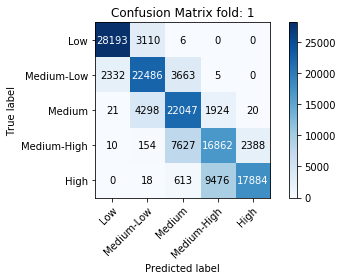

ACCURACY FOLD OBTAIN: 0.7508330941200256
PRECISION LOW:       0.9226665793952088
PRECISION MEDIUM-LOW: 0.7478879797778222
PRECISION MEDIUM:    0.6492814230180233
PRECISION MEDIUM-HIGH: 0.596525984363392
PRECISION HIGH:      0.8813325448452592
RECALL LOW:          0.9004759014979719
RECALL MEDIUM-LOW:   0.7893702169486766
RECALL MEDIUM:       0.7787707523843165
RECALL MEDIUM-HIGH:  0.623571613475833
RECALL HIGH:         0.6389196527455253
FOLD NUMBER:             2


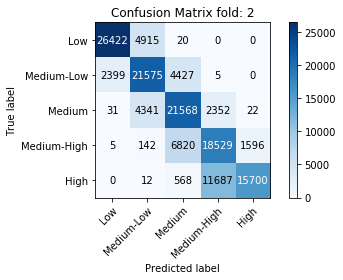

ACCURACY FOLD OBTAIN: 0.7251425385475159
PRECISION LOW:       0.9156183941504661
PRECISION MEDIUM-LOW: 0.6963046635468775
PRECISION MEDIUM:    0.645690506840703
PRECISION MEDIUM-HIGH: 0.5688453627237282
PRECISION HIGH:      0.9065711975978751
RECALL LOW:          0.8426188729789201
RECALL MEDIUM-LOW:   0.7595226360628037
RECALL MEDIUM:       0.7617433071978527
RECALL MEDIUM-HIGH:  0.6839288350804665
RECALL HIGH:         0.5613759073193406
FOLD NUMBER:             3


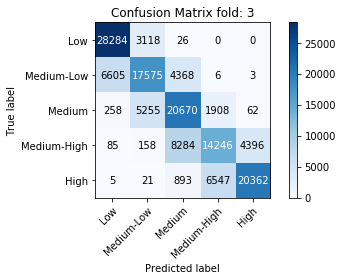

ACCURACY FOLD OBTAIN: 0.7065846920013428
PRECISION LOW:       0.802679002185203
PRECISION MEDIUM-LOW: 0.672675776017147
PRECISION MEDIUM:    0.6036622762185684
PRECISION MEDIUM-HIGH: 0.6273836261945656
PRECISION HIGH:      0.8202876364661805
RECALL LOW:          0.8999618174875906
RECALL MEDIUM-LOW:   0.6154357950765137
RECALL MEDIUM:       0.7342023940610237
RECALL MEDIUM-HIGH:  0.52434760204645
RECALL HIGH:         0.7317090700014374
ACCURACY OBTAIN:     0.7275201082229614
9      	 [7.20812916e-02 5.31055104e-01 4.49949259e-01 2.00000000e+00
 2.37000000e+02 2.26000000e+02 6.30000000e+01 2.00000000e+00]. 	  0.7275201082229614 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.04813
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       152

RUN NUMBER:             16
FOLD NUMBER:             1


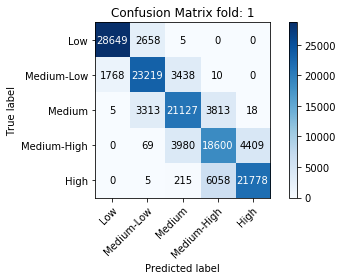

ACCURACY FOLD OBTAIN: 0.7920593619346619
PRECISION LOW:       0.9417198080336598
PRECISION MEDIUM-LOW: 0.7934322033898306
PRECISION MEDIUM:    0.7344689727098905
PRECISION MEDIUM-HIGH: 0.6530669569186475
PRECISION HIGH:      0.8310627742797176
RECALL LOW:          0.914952733776188
RECALL MEDIUM-LOW:   0.8165640935466855
RECALL MEDIUM:       0.7471707455085584
RECALL MEDIUM-HIGH:  0.6874122255894745
RECALL HIGH:         0.776233247790134
FOLD NUMBER:             2


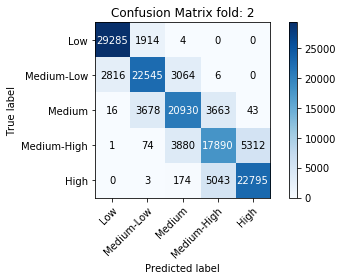

ACCURACY FOLD OBTAIN: 0.7925679087638855
PRECISION LOW:       0.9117940095896382
PRECISION MEDIUM-LOW: 0.7990713830013468
PRECISION MEDIUM:    0.7461143590474832
PRECISION MEDIUM-HIGH: 0.6725058266295767
PRECISION HIGH:      0.8097690941385435
RECALL LOW:          0.9385315514533858
RECALL MEDIUM-LOW:   0.7929724596391263
RECALL MEDIUM:       0.7387927991528415
RECALL MEDIUM-HIGH:  0.6587620134771882
RECALL HIGH:         0.8136712475459575
FOLD NUMBER:             3


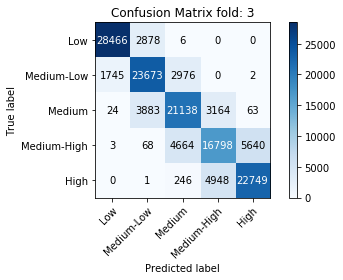

ACCURACY FOLD OBTAIN: 0.7882348895072937
PRECISION LOW:       0.9413982406243799
PRECISION MEDIUM-LOW: 0.7760875979411861
PRECISION MEDIUM:    0.7281433000344472
PRECISION MEDIUM-HIGH: 0.674347651545564
PRECISION HIGH:      0.7995009488999789
RECALL LOW:          0.9080063795853269
RECALL MEDIUM-LOW:   0.8336737568671644
RECALL MEDIUM:       0.7476655348047538
RECALL MEDIUM-HIGH:  0.6181871710889486
RECALL HIGH:         0.8140924706555969
ACCURACY OBTAIN:     0.790954053401947
10     	 [4.81307167e-02 6.45575591e-01 1.24854641e-01 1.00000000e+00
 1.52000000e+02 2.46000000e+02 7.60000000e+01 2.00000000e+00]. 	  0.790954053401947 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01014
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       250
TRY SECOND LAYER:      131

RUN NUMBER:             17
FOLD NUMBER:             1


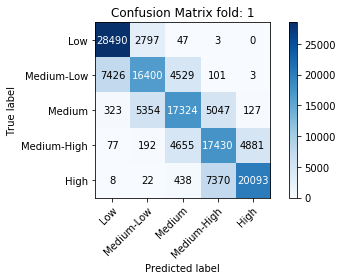

ACCURACY FOLD OBTAIN: 0.6967939734458923
PRECISION LOW:       0.7843299196123775
PRECISION MEDIUM-LOW: 0.6622249141934181
PRECISION MEDIUM:    0.641796021190679
PRECISION MEDIUM-HIGH: 0.5819505191813295
PRECISION HIGH:      0.8003903760356915
RECALL LOW:          0.9091489293806044
RECALL MEDIUM-LOW:   0.5762676130573808
RECALL MEDIUM:       0.614871339840284
RECALL MEDIUM-HIGH:  0.6399853130163393
RECALL HIGH:         0.7193799004690129
FOLD NUMBER:             2


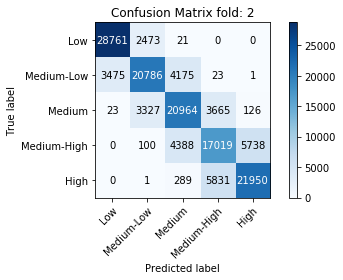

ACCURACY FOLD OBTAIN: 0.7648670077323914
PRECISION LOW:       0.8915651446108063
PRECISION MEDIUM-LOW: 0.7788811031588414
PRECISION MEDIUM:    0.7026175553842544
PRECISION MEDIUM-HIGH: 0.641306805335745
PRECISION HIGH:      0.789142548984361
RECALL LOW:          0.9202047672372421
RECALL MEDIUM-LOW:   0.7303583977512298
RECALL MEDIUM:       0.7459170966020281
RECALL MEDIUM-HIGH:  0.6246650761607634
RECALL HIGH:         0.7819457803427025
FOLD NUMBER:             3


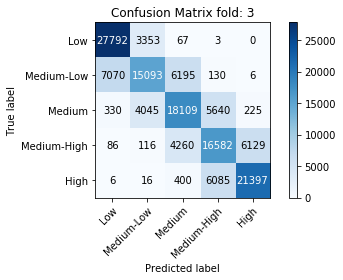

ACCURACY FOLD OBTAIN: 0.6914660930633545
PRECISION LOW:       0.7876657975286249
PRECISION MEDIUM-LOW: 0.6671528974937011
PRECISION MEDIUM:    0.6237814749750267
PRECISION MEDIUM-HIGH: 0.5830520393811534
PRECISION HIGH:      0.7708686097200707
RECALL LOW:          0.8903411821239788
RECALL MEDIUM-LOW:   0.5296904611497157
RECALL MEDIUM:       0.6387879643020918
RECALL MEDIUM-HIGH:  0.6102381040002944
RECALL HIGH:         0.766807626146789
ACCURACY OBTAIN:     0.7177090247472128
11     	 [1.01407846e-02 7.65915644e-01 1.00723623e-01 2.00000000e+00
 2.50000000e+02 1.31000000e+02 8.50000000e+01 2.00000000e+00]. 	  0.7177090247472128 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.09005
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       296
TRY SECOND LAYER:      229

RUN NUMBER:             18
FOLD NUMBER:             1


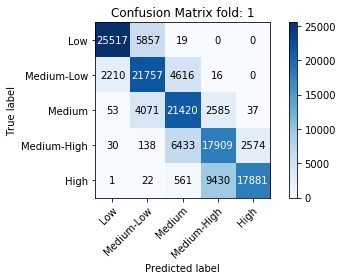

ACCURACY FOLD OBTAIN: 0.7299579977989197
PRECISION LOW:       0.9175146524756391
PRECISION MEDIUM-LOW: 0.6832155754435547
PRECISION MEDIUM:    0.6481285364156253
PRECISION MEDIUM-HIGH: 0.5981629926519706
PRECISION HIGH:      0.8725844231895373
RECALL LOW:          0.8128245150192718
RECALL MEDIUM-LOW:   0.7607608657645373
RECALL MEDIUM:       0.7604913725768657
RECALL MEDIUM-HIGH:  0.6612391079604194
RECALL HIGH:         0.6410109338591146
FOLD NUMBER:             2


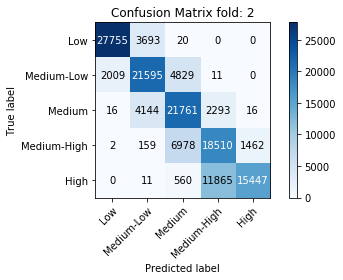

ACCURACY FOLD OBTAIN: 0.7340431213378906
PRECISION LOW:       0.931938754952656
PRECISION MEDIUM-LOW: 0.7295115194919263
PRECISION MEDIUM:    0.6372554761625864
PRECISION MEDIUM-HIGH: 0.566418801064904
PRECISION HIGH:      0.9126735598227474
RECALL LOW:          0.8820071183424432
RECALL MEDIUM-LOW:   0.7592110814231472
RECALL MEDIUM:       0.7708466170740347
RECALL MEDIUM-HIGH:  0.6827486997897533
RECALL HIGH:         0.5539934727253165
FOLD NUMBER:             3


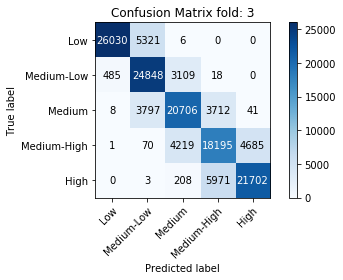

ACCURACY FOLD OBTAIN: 0.778852105140686
PRECISION LOW:       0.9813753581661891
PRECISION MEDIUM-LOW: 0.7299861923088222
PRECISION MEDIUM:    0.7330076465590484
PRECISION MEDIUM-HIGH: 0.6522440493260683
PRECISION HIGH:      0.8211745118813379
RECALL LOW:          0.8301176770736997
RECALL MEDIUM-LOW:   0.873085031623331
RECALL MEDIUM:       0.7325926974242853
RECALL MEDIUM-HIGH:  0.6696724328303275
RECALL HIGH:         0.7782957968727585
ACCURACY OBTAIN:     0.7476177414258321
12     	 [9.00488592e-02 2.70797928e-01 1.13876068e-01 2.00000000e+00
 2.96000000e+02 2.29000000e+02 7.30000000e+01 2.00000000e+00]. 	  0.7476177414258321 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.03601
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       253

RUN NUMBER:             19
FOLD NUMBER:             1


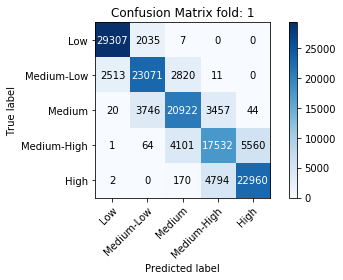

ACCURACY FOLD OBTAIN: 0.7949866056442261
PRECISION LOW:       0.9203592626322896
PRECISION MEDIUM-LOW: 0.7978627749342925
PRECISION MEDIUM:    0.7466809421841542
PRECISION MEDIUM-HIGH: 0.6796929518492673
PRECISION HIGH:      0.8038089903374878
RECALL LOW:          0.9348623560560145
RECALL MEDIUM-LOW:   0.8119303184937533
RECALL MEDIUM:       0.7422044059739614
RECALL MEDIUM-HIGH:  0.6431873211534228
RECALL HIGH:         0.8221728854830623
FOLD NUMBER:             2


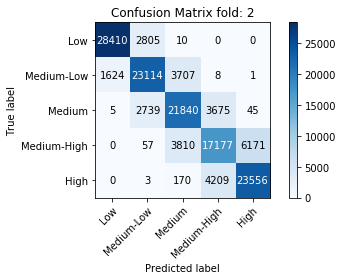

ACCURACY FOLD OBTAIN: 0.7971230149269104
PRECISION LOW:       0.9457704983521422
PRECISION MEDIUM-LOW: 0.8048610627481022
PRECISION MEDIUM:    0.7394115854690727
PRECISION MEDIUM-HIGH: 0.6851888786948024
PRECISION HIGH:      0.7911866456185134
RECALL LOW:          0.9098478783026421
RECALL MEDIUM-LOW:   0.8123286708371407
RECALL MEDIUM:       0.7716223855285472
RECALL MEDIUM-HIGH:  0.6311592871578173
RECALL HIGH:         0.8431526952537762
FOLD NUMBER:             3


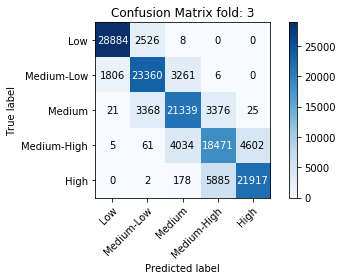

ACCURACY FOLD OBTAIN: 0.7962483167648315
PRECISION LOW:       0.9403568172939185
PRECISION MEDIUM-LOW: 0.7968073131630112
PRECISION MEDIUM:    0.7404233171408744
PRECISION MEDIUM-HIGH: 0.6659095825221717
PRECISION HIGH:      0.8256856540084389
RECALL LOW:          0.9193455980648036
RECALL MEDIUM-LOW:   0.8215805578025533
RECALL MEDIUM:       0.7586121085001244
RECALL MEDIUM-HIGH:  0.6797556397894969
RECALL HIGH:         0.7832535201200772
ACCURACY OBTAIN:     0.7961193124453226
13     	 [3.60112845e-02 1.06822115e-01 5.49352651e-01 1.00000000e+00
 2.53000000e+02 1.42000000e+02 9.00000000e+01 2.00000000e+00]. 	  0.7961193124453226 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.04362
TRY RHO:             0.32994
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       287

RUN NUMBER:             20
FOLD NUMBER:             1


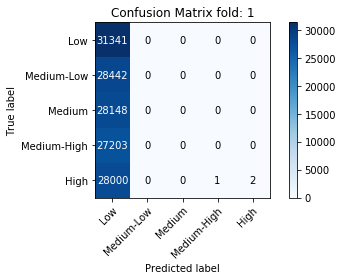

ACCURACY FOLD OBTAIN: 0.21897202730178833
PRECISION LOW:       0.21896265038355667


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        1.0
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         7.142091918722994e-05
FOLD NUMBER:             2


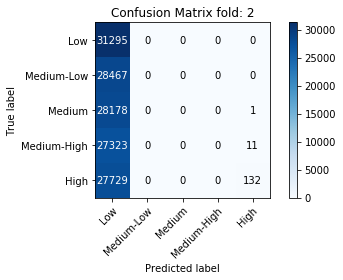

ACCURACY FOLD OBTAIN: 0.2195604145526886
PRECISION LOW:       0.21885839767259707


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:      0.9166666666666666
RECALL LOW:            1.0
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         0.004737805534618284
FOLD NUMBER:             3


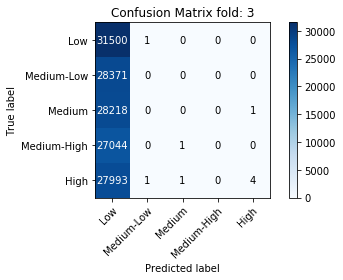

ACCURACY FOLD OBTAIN: 0.22009991109371185
PRECISION LOW:       0.22008579852717186


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:   0.0
PRECISION MEDIUM:      0.0
PRECISION MEDIUM-HIGH:   0.0
PRECISION HIGH:        0.8
RECALL LOW:          0.9999682549760325
RECALL MEDIUM-LOW:     0.0
RECALL MEDIUM:         0.0
RECALL MEDIUM-HIGH:    0.0
RECALL HIGH:         0.00014286224508018144
ACCURACY OBTAIN:     0.21954411764939627
14     	 [4.36163853e-02 8.89438863e-01 3.29938322e-01 1.00000000e+00
 2.87000000e+02 1.67000000e+02 7.60000000e+01 1.00000000e+00]. 	  0.21954411764939627 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.03085
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       175

RUN NUMBER:             21
FOLD NUMBER:             1


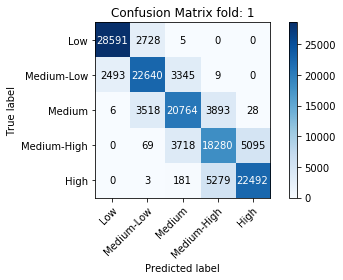

ACCURACY FOLD OBTAIN: 0.7878256440162659
PRECISION LOW:       0.9196204567385011
PRECISION MEDIUM-LOW: 0.7818219490296291
PRECISION MEDIUM:    0.7412272873308821
PRECISION MEDIUM-HIGH: 0.665671315684061
PRECISION HIGH:      0.8144848814050335
RECALL LOW:          0.9127506065636573
RECALL MEDIUM-LOW:   0.7947484817636115
RECALL MEDIUM:       0.7360771385018966
RECALL MEDIUM-HIGH:  0.6729990427803549
RECALL HIGH:         0.8045787873367912
FOLD NUMBER:             2


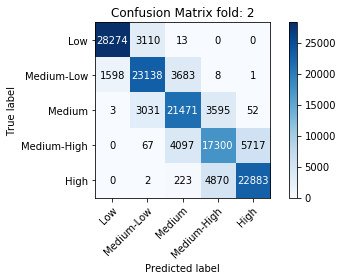

ACCURACY FOLD OBTAIN: 0.7899200916290283
PRECISION LOW:       0.9464100418410042
PRECISION MEDIUM-LOW: 0.7884012539184952
PRECISION MEDIUM:    0.7281513887475837
PRECISION MEDIUM-HIGH: 0.6712451014627712
PRECISION HIGH:      0.7986249258367362
RECALL LOW:          0.9005318979520336
RECALL MEDIUM-LOW:   0.813915857605178
RECALL MEDIUM:       0.7626811594202898
RECALL MEDIUM-HIGH:  0.6364740075788234
RECALL HIGH:         0.8178926299235113
FOLD NUMBER:             3


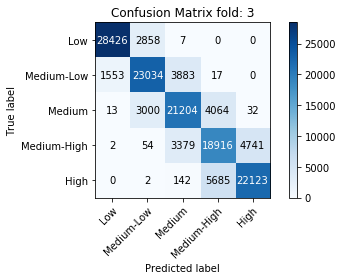

ACCURACY FOLD OBTAIN: 0.7943759560585022
PRECISION LOW:       0.9477228779089151
PRECISION MEDIUM-LOW: 0.7957026392151444
PRECISION MEDIUM:    0.7410099598112878
PRECISION MEDIUM-HIGH: 0.6595077051809497
PRECISION HIGH:      0.8225386674598454
RECALL LOW:          0.9084401265539612
RECALL MEDIUM-LOW:   0.808579351985116
RECALL MEDIUM:       0.7489139264648748
RECALL MEDIUM-HIGH:  0.6982134947586003
RECALL HIGH:         0.7914639381797367
ACCURACY OBTAIN:     0.7907072305679321
15     	 [3.08474251e-02 8.73060807e-01 3.89812085e-01 1.00000000e+00
 1.75000000e+02 2.25000000e+02 8.90000000e+01 2.00000000e+00]. 	  0.7907072305679321 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05566
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       212

RUN NUMBER:             22
FOLD NUMBER:             1


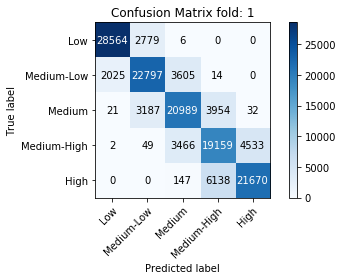

ACCURACY FOLD OBTAIN: 0.7907040119171143
PRECISION LOW:       0.9330981314517183
PRECISION MEDIUM-LOW: 0.7912328196584756
PRECISION MEDIUM:    0.7439478254705277
PRECISION MEDIUM-HIGH: 0.6546728173586195
PRECISION HIGH:      0.8259958071278826
RECALL LOW:          0.9111614405563175
RECALL MEDIUM-LOW:   0.8015540944411237
RECALL MEDIUM:       0.7447397367207181
RECALL MEDIUM-HIGH:  0.7041420118343196
RECALL HIGH:         0.7751743874083348
FOLD NUMBER:             2


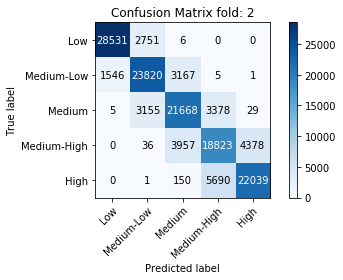

ACCURACY FOLD OBTAIN: 0.8026003241539001
PRECISION LOW:       0.9484409281297786
PRECISION MEDIUM-LOW: 0.8003225481302289
PRECISION MEDIUM:    0.7485145778637557
PRECISION MEDIUM-HIGH: 0.6747562374533983
PRECISION HIGH:      0.8333270314213332
RECALL LOW:          0.9118831500894912
RECALL MEDIUM-LOW:   0.8346473247135499
RECALL MEDIUM:       0.7674163272534089
RECALL MEDIUM-HIGH:  0.6921747444289181
RECALL HIGH:         0.7904949784791966
FOLD NUMBER:             3


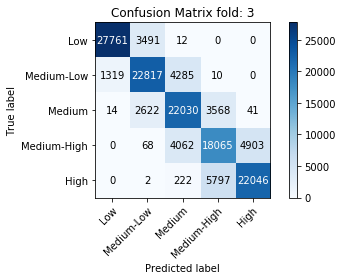

ACCURACY FOLD OBTAIN: 0.787501335144043
PRECISION LOW:       0.9541829930569877
PRECISION MEDIUM-LOW: 0.7867931034482759
PRECISION MEDIUM:    0.7196759334879619
PRECISION MEDIUM-HIGH: 0.6583454810495627
PRECISION HIGH:      0.816821044831419
RECALL LOW:          0.8879541965199591
RECALL MEDIUM-LOW:   0.8025394815518272
RECALL MEDIUM:       0.7791335101679929
RECALL MEDIUM-HIGH:  0.6666543656358402
RECALL HIGH:         0.7854776071543094
ACCURACY OBTAIN:     0.7936018904050192
16     	 [5.56613016e-02 5.69557217e-01 1.28668361e-01 1.00000000e+00
 2.12000000e+02 1.31000000e+02 7.00000000e+01 2.00000000e+00]. 	  0.7936018904050192 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.09462
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       274

RUN NUMBER:             23
FOLD NUMBER:             1


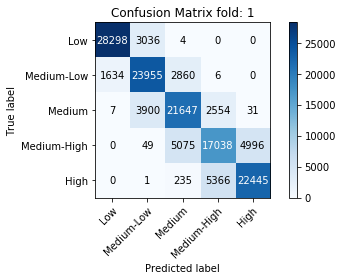

ACCURACY FOLD OBTAIN: 0.7921292185783386
PRECISION LOW:       0.9451885500517719
PRECISION MEDIUM-LOW: 0.7742154422933971
PRECISION MEDIUM:    0.7258978572147144
PRECISION MEDIUM-HIGH: 0.6825028040378145
PRECISION HIGH:      0.817013686662784
RECALL LOW:          0.9029931712298168
RECALL MEDIUM-LOW:   0.841855561412757
RECALL MEDIUM:       0.7692881765521162
RECALL MEDIUM-HIGH:  0.6273657854039325
RECALL HIGH:         0.8002638428352409
FOLD NUMBER:             2


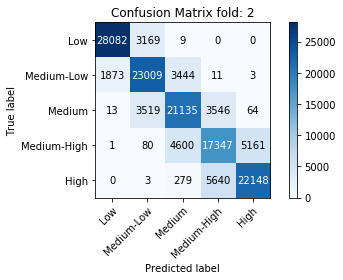

ACCURACY FOLD OBTAIN: 0.780523419380188
PRECISION LOW:       0.9370349361006374
PRECISION MEDIUM-LOW: 0.772632639355272
PRECISION MEDIUM:    0.717243017612923
PRECISION MEDIUM-HIGH: 0.6535186859553949
PRECISION HIGH:      0.8090298071303331
RECALL LOW:          0.8983365323096609
RECALL MEDIUM-LOW:   0.8118913196894848
RECALL MEDIUM:       0.747427237684337
RECALL MEDIUM-HIGH:  0.6380153738644304
RECALL HIGH:         0.7890274314214464
FOLD NUMBER:             3


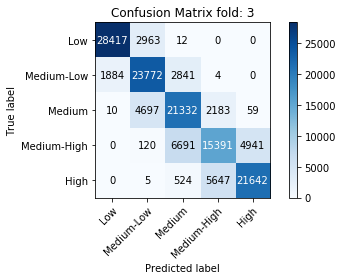

ACCURACY FOLD OBTAIN: 0.7723757028579712
PRECISION LOW:       0.9375144337039358
PRECISION MEDIUM-LOW: 0.7533035459644453
PRECISION MEDIUM:    0.6793630573248408
PRECISION MEDIUM-HIGH: 0.6626910656620022
PRECISION HIGH:      0.8123264019217776
RECALL LOW:          0.9052306320081549
RECALL MEDIUM-LOW:   0.8340759973334269
RECALL MEDIUM:       0.7542873307167356
RECALL MEDIUM-HIGH:  0.5670338577165384
RECALL HIGH:         0.7779854770292616
ACCURACY OBTAIN:     0.7816761136054993
17     	 [9.46249129e-02 1.28800685e-01 3.67672476e-01 1.00000000e+00
 2.74000000e+02 2.19000000e+02 6.80000000e+01 2.00000000e+00]. 	  0.7816761136054993 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05362
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       283

RUN NUMBER:             24
FOLD NUMBER:             1


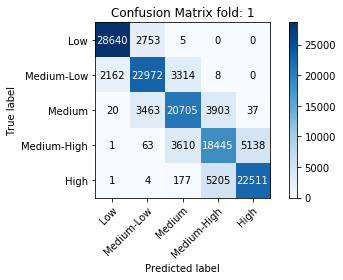

ACCURACY FOLD OBTAIN: 0.7913607358932495
PRECISION LOW:       0.9291461199065663
PRECISION MEDIUM-LOW: 0.7852332934541104
PRECISION MEDIUM:    0.744489590449822
PRECISION MEDIUM-HIGH: 0.669242770581619
PRECISION HIGH:      0.8130824243299862
RECALL LOW:          0.912160010191732
RECALL MEDIUM-LOW:   0.8072814169243745
RECALL MEDIUM:       0.736099260523322
RECALL MEDIUM-HIGH:  0.6767069009795649
RECALL HIGH:         0.8069037206968241
FOLD NUMBER:             2


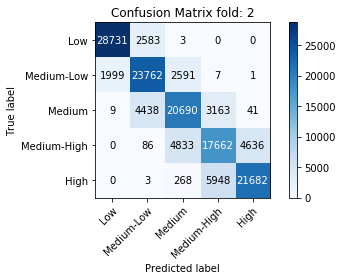

ACCURACY FOLD OBTAIN: 0.7861544489860535
PRECISION LOW:       0.9346758189921598
PRECISION MEDIUM-LOW: 0.7696942213008552
PRECISION MEDIUM:    0.728906112383301
PRECISION MEDIUM-HIGH: 0.6595220313666915
PRECISION HIGH:      0.8225341426403642
RECALL LOW:          0.9174250407127119
RECALL MEDIUM-LOW:   0.8378702397743301
RECALL MEDIUM:       0.7300377544899616
RECALL MEDIUM-HIGH:  0.6489326523863762
RECALL HIGH:         0.7771047632701337
FOLD NUMBER:             3


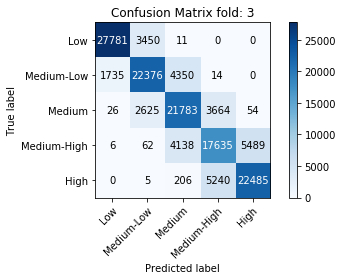

ACCURACY FOLD OBTAIN: 0.7828972935676575
PRECISION LOW:       0.9401989982401516
PRECISION MEDIUM-LOW: 0.7846272529630409
PRECISION MEDIUM:    0.714477827341905
PRECISION MEDIUM-HIGH: 0.6641434112906263
PRECISION HIGH:      0.8022334808049094
RECALL LOW:          0.8892196402278983
RECALL MEDIUM-LOW:   0.7858121158911325
RECALL MEDIUM:       0.7737638533674339
RECALL MEDIUM-HIGH:  0.6452616172703989
RECALL HIGH:         0.8048754295532646
ACCURACY OBTAIN:     0.7868041594823202
18     	 [5.36216284e-02 8.14487092e-01 4.53647148e-01 1.00000000e+00
 2.83000000e+02 1.63000000e+02 8.70000000e+01 2.00000000e+00]. 	  0.7868041594823202 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05922
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       293

RUN NUMBER:             25
FOLD NUMBER:             1


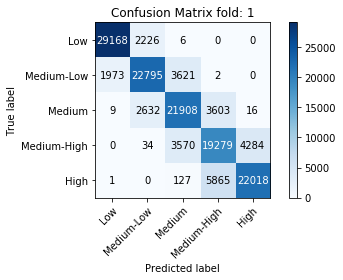

ACCURACY FOLD OBTAIN: 0.8045997619628906
PRECISION LOW:       0.9363423325093897
PRECISION MEDIUM-LOW: 0.8233105789720807
PRECISION MEDIUM:    0.7494526546250684
PRECISION MEDIUM-HIGH: 0.6705972381648058
PRECISION HIGH:      0.8366137244471464
RECALL LOW:          0.9289171974522293
RECALL MEDIUM-LOW:   0.8028952837166707
RECALL MEDIUM:       0.7777619994319795
RECALL MEDIUM-HIGH:  0.7096477343836272
RECALL HIGH:         0.7860483381528686
FOLD NUMBER:             2


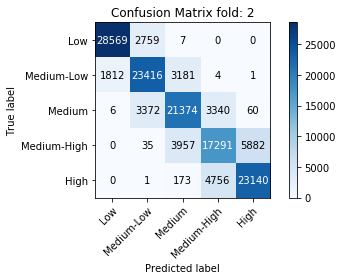

ACCURACY FOLD OBTAIN: 0.7949782013893127
PRECISION LOW:       0.9401717839865732
PRECISION MEDIUM-LOW: 0.7915356792752595
PRECISION MEDIUM:    0.7449463265021609
PRECISION MEDIUM-HIGH: 0.6809893269268639
PRECISION HIGH:      0.7956538183818725
RECALL LOW:          0.9117280995691719
RECALL MEDIUM-LOW:   0.8241007953825579
RECALL MEDIUM:       0.7592355782892868
RECALL MEDIUM-HIGH:  0.6365175777655071
RECALL HIGH:         0.8243676522978268
FOLD NUMBER:             3


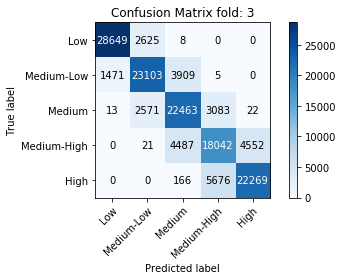

ACCURACY FOLD OBTAIN: 0.800125777721405
PRECISION LOW:       0.9507516676069425
PRECISION MEDIUM-LOW: 0.8157838983050848
PRECISION MEDIUM:    0.7238423613572649
PRECISION MEDIUM-HIGH: 0.6730582705364471
PRECISION HIGH:      0.8296017583727602
RECALL LOW:          0.9158301898855572
RECALL MEDIUM-LOW:   0.8109730412805392
RECALL MEDIUM:       0.7979184427394146
RECALL MEDIUM-HIGH:  0.6657073278724818
RECALL HIGH:         0.792180996762833
ACCURACY OBTAIN:     0.7999012470245361
19     	 [5.92161567e-02 2.18607792e-01 7.52640659e-01 1.00000000e+00
 2.93000000e+02 1.63000000e+02 5.20000000e+01 2.00000000e+00]. 	  0.7999012470245361 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01457
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       287
TRY SECOND LAYER:      120

RUN NUMBER:             26
FOLD NUMBER:             1


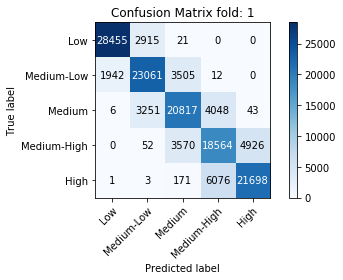

ACCURACY FOLD OBTAIN: 0.786624014377594
PRECISION LOW:       0.9358965925536114
PRECISION MEDIUM-LOW: 0.7875486647086948
PRECISION MEDIUM:    0.741240564022219
PRECISION MEDIUM-HIGH: 0.646829268292683
PRECISION HIGH:      0.8136648291896351
RECALL LOW:          0.9064700073269408
RECALL MEDIUM-LOW:   0.8085904628330995
RECALL MEDIUM:       0.7391088230072785
RECALL MEDIUM-HIGH:  0.6847152552375332
RECALL HIGH:         0.7763426240652618
FOLD NUMBER:             2


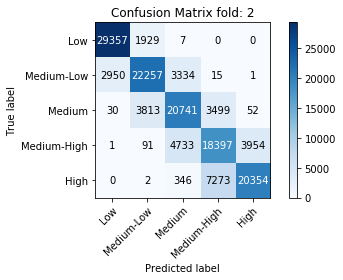

ACCURACY FOLD OBTAIN: 0.776226818561554
PRECISION LOW:       0.9078174284123941
PRECISION MEDIUM-LOW: 0.7922896198205895
PRECISION MEDIUM:    0.7112581873049622
PRECISION MEDIUM-HIGH: 0.6303796600877193
PRECISION HIGH:      0.8355157834243258
RECALL LOW:          0.9381331288147509
RECALL MEDIUM-LOW:   0.7793885912385755
RECALL MEDIUM:       0.737195663763995
RECALL MEDIUM-HIGH:  0.6769576096555785
RECALL HIGH:         0.7275781948168007
FOLD NUMBER:             3


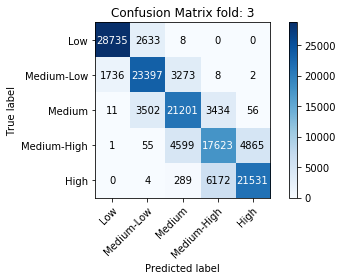

ACCURACY FOLD OBTAIN: 0.785880446434021
PRECISION LOW:       0.9426565626742774
PRECISION MEDIUM-LOW: 0.790679598526579
PRECISION MEDIUM:    0.721859039836568
PRECISION MEDIUM-HIGH: 0.6470242684583472
PRECISION HIGH:      0.8139033794511227
RECALL LOW:          0.9158273839877613
RECALL MEDIUM-LOW:   0.8233741554054054
RECALL MEDIUM:       0.7517018862572685
RECALL MEDIUM-HIGH:  0.6492650038684007
RECALL HIGH:         0.7690741534504929
ACCURACY OBTAIN:     0.782910426457723
20     	 [1.45698222e-02 8.82214196e-01 9.27992923e-01 2.00000000e+00
 2.87000000e+02 1.20000000e+02 9.30000000e+01 2.00000000e+00]. 	  0.782910426457723 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.03182
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       200

RUN NUMBER:             27
FOLD NUMBER:             1


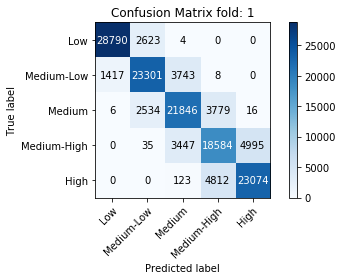

ACCURACY FOLD OBTAIN: 0.8075829744338989
PRECISION LOW:       0.9529010690762255
PRECISION MEDIUM-LOW: 0.8177798055662794
PRECISION MEDIUM:    0.7490998868429174
PRECISION MEDIUM-HIGH: 0.6836625832321671
PRECISION HIGH:      0.821577354459676
RECALL LOW:          0.9163828500493364
RECALL MEDIUM-LOW:   0.8184692121254699
RECALL MEDIUM:       0.7752031510592243
RECALL MEDIUM-HIGH:  0.6867447618343742
RECALL HIGH:         0.823806633582063
FOLD NUMBER:             2


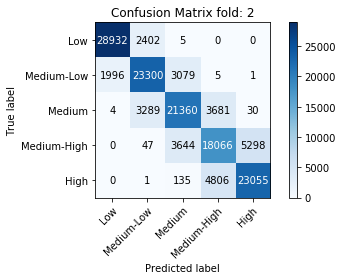

ACCURACY FOLD OBTAIN: 0.8014265894889832
PRECISION LOW:       0.9353420406051985
PRECISION MEDIUM-LOW: 0.8023692275904818
PRECISION MEDIUM:    0.7568295361938844
PRECISION MEDIUM-HIGH: 0.6802470065516981
PRECISION HIGH:      0.8122533821871477
RECALL LOW:          0.9231947413765595
RECALL MEDIUM-LOW:   0.8209717768929918
RECALL MEDIUM:       0.7530672683683542
RECALL MEDIUM-HIGH:  0.6677508778414342
RECALL HIGH:         0.8234810872593492
FOLD NUMBER:             3


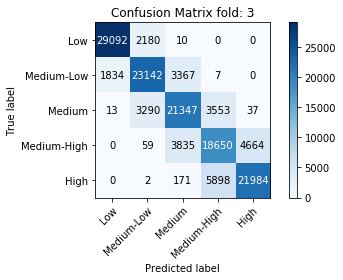

ACCURACY FOLD OBTAIN: 0.7979530096054077
PRECISION LOW:       0.9403018843530818
PRECISION MEDIUM-LOW: 0.8071007568095421
PRECISION MEDIUM:    0.7430212321615036
PRECISION MEDIUM-HIGH: 0.6635121673544898
PRECISION HIGH:      0.8238336143901068
RECALL LOW:          0.9299916885109648
RECALL MEDIUM-LOW:   0.8162962962962963
RECALL MEDIUM:       0.755913597733711
RECALL MEDIUM-HIGH:  0.6854601587768303
RECALL HIGH:         0.7836036357155587
ACCURACY OBTAIN:     0.8023208578427633
21     	 [3.18210318e-02 8.39259042e-01 4.22039770e-01 1.00000000e+00
 2.00000000e+02 2.34000000e+02 8.20000000e+01 2.00000000e+00]. 	  0.8023208578427633 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.02379
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       298
TRY SECOND LAYER:      133

RUN NUMBER:             28
FOLD NUMBER:             1


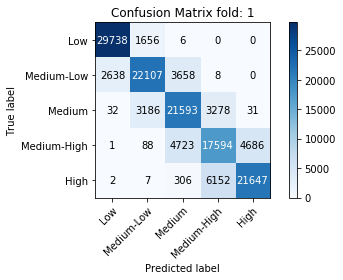

ACCURACY FOLD OBTAIN: 0.7872108817100525
PRECISION LOW:       0.9175279997531702
PRECISION MEDIUM-LOW: 0.8174456441354829
PRECISION MEDIUM:    0.7129696889651984
PRECISION MEDIUM-HIGH: 0.6508582420834567
PRECISION HIGH:      0.8210817781823699
RECALL LOW:          0.9470700636942675
RECALL MEDIUM-LOW:   0.7781141107317588
RECALL MEDIUM:       0.7678876244665719
RECALL MEDIUM-HIGH:  0.6494168020079728
RECALL HIGH:         0.7699722558156079
FOLD NUMBER:             2


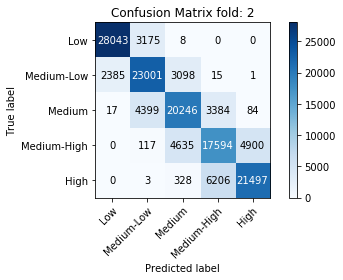

ACCURACY FOLD OBTAIN: 0.771161675453186
PRECISION LOW:       0.9211036294958121
PRECISION MEDIUM-LOW: 0.749340283433784
PRECISION MEDIUM:    0.715027370651598
PRECISION MEDIUM-HIGH: 0.6468620169859186
PRECISION HIGH:      0.811758930594366
RECALL LOW:          0.898065714468712
RECALL MEDIUM-LOW:   0.8070526315789474
RECALL MEDIUM:       0.7197298258087451
RECALL MEDIUM-HIGH:  0.6457461645746164
RECALL HIGH:         0.7668188628094457
FOLD NUMBER:             3


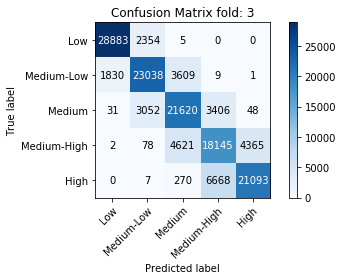

ACCURACY FOLD OBTAIN: 0.7879204750061035
PRECISION LOW:       0.9394067520978339
PRECISION MEDIUM-LOW: 0.8075291808335378
PRECISION MEDIUM:    0.7176763485477179
PRECISION MEDIUM-HIGH: 0.6428014737140428
PRECISION HIGH:      0.8269494648527855
RECALL LOW:          0.9244926701235516
RECALL MEDIUM-LOW:   0.8087197669112227
RECALL MEDIUM:       0.7678374826863658
RECALL MEDIUM-HIGH:  0.6668259159898571
RECALL HIGH:         0.7523004493901134
ACCURACY OBTAIN:     0.7820976773897806
22     	 [2.37872664e-02 8.79415293e-01 9.15901226e-01 2.00000000e+00
 2.98000000e+02 1.33000000e+02 7.50000000e+01 2.00000000e+00]. 	  0.7820976773897806 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01172
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       281
TRY SECOND LAYER:      138

RUN NUMBER:             29
FOLD NUMBER:             1


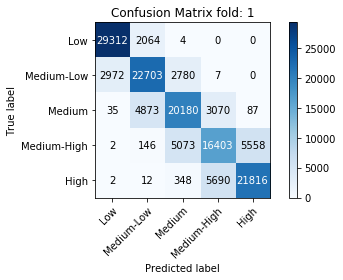

ACCURACY FOLD OBTAIN: 0.7713868618011475
PRECISION LOW:       0.9068465179593478
PRECISION MEDIUM-LOW: 0.7618967715954091
PRECISION MEDIUM:    0.7109388761669896
PRECISION MEDIUM-HIGH: 0.6516885180770758
PRECISION HIGH:      0.7944357452387022
RECALL LOW:          0.9340981516889739
RECALL MEDIUM-LOW:   0.7976600379453306
RECALL MEDIUM:       0.7144627367675694
RECALL MEDIUM-HIGH:  0.6034508130380398
RECALL HIGH:         0.7828333572556337
FOLD NUMBER:             2


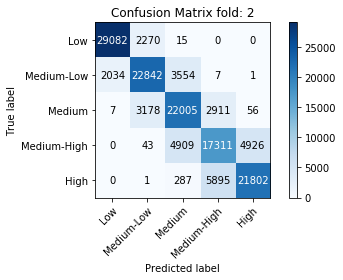

ACCURACY FOLD OBTAIN: 0.7897524237632751
PRECISION LOW:       0.9344214889310156
PRECISION MEDIUM-LOW: 0.8061692666054916
PRECISION MEDIUM:    0.7151446213844654
PRECISION MEDIUM-HIGH: 0.662647374062165
PRECISION HIGH:      0.8139630390143737
RECALL LOW:          0.9271527401409124
RECALL MEDIUM-LOW:   0.8032210422673887
RECALL MEDIUM:       0.7815108143623255
RECALL MEDIUM-HIGH:  0.6366913089852514
RECALL HIGH:         0.7790602108272289
FOLD NUMBER:             3


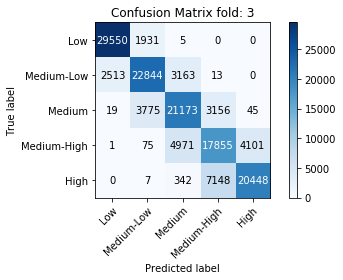

ACCURACY FOLD OBTAIN: 0.7815698385238647
PRECISION LOW:       0.9210485303743415
PRECISION MEDIUM-LOW: 0.7978485610505728
PRECISION MEDIUM:    0.7140014837795913
PRECISION MEDIUM-HIGH: 0.6337853187562118
PRECISION HIGH:      0.831422298121493
RECALL LOW:          0.9385123546973257
RECALL MEDIUM-LOW:   0.8006168296358602
RECALL MEDIUM:       0.7516685600681624
RECALL MEDIUM-HIGH:  0.661222827093286
RECALL HIGH:         0.7317230273752013
ACCURACY OBTAIN:     0.7809030413627625
23     	 [1.17226095e-02 1.53876513e-01 3.51209528e-01 2.00000000e+00
 2.81000000e+02 1.38000000e+02 6.40000000e+01 2.00000000e+00]. 	  0.7809030413627625 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.05495
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       223

RUN NUMBER:             30
FOLD NUMBER:             1


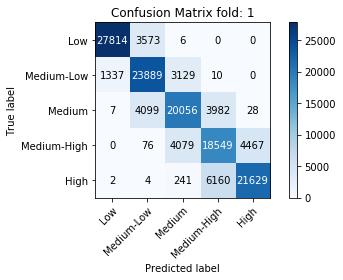

ACCURACY FOLD OBTAIN: 0.782027006149292
PRECISION LOW:       0.953840877914952
PRECISION MEDIUM-LOW: 0.7550014222053665
PRECISION MEDIUM:    0.7290174839155247
PRECISION MEDIUM-HIGH: 0.6462841015992474
PRECISION HIGH:      0.8279359975501455
RECALL LOW:          0.8859936928614659
RECALL MEDIUM-LOW:   0.8421998942358541
RECALL MEDIUM:       0.7119125372710493
RECALL MEDIUM-HIGH:  0.6826763829082477
RECALL HIGH:         0.7714723926380368
FOLD NUMBER:             2


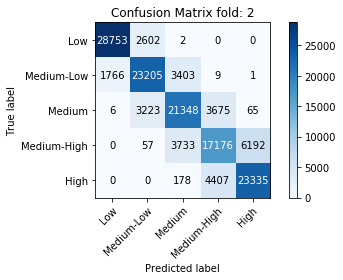

ACCURACY FOLD OBTAIN: 0.7951668500900269
PRECISION LOW:       0.9419492219492219
PRECISION MEDIUM-LOW: 0.7977790765634132
PRECISION MEDIUM:    0.7447669550655875
PRECISION MEDIUM-HIGH: 0.679779950132584
PRECISION HIGH:      0.7885310715371878
RECALL LOW:          0.9169563414867493
RECALL MEDIUM-LOW:   0.8175380496054115
RECALL MEDIUM:       0.7538934209132323
RECALL MEDIUM-HIGH:  0.6324471610575153
RECALL HIGH:         0.8357808022922636
FOLD NUMBER:             3


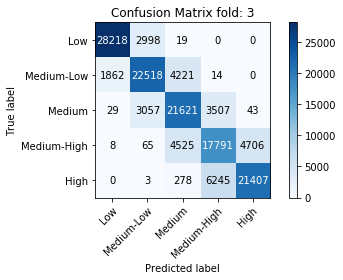

ACCURACY FOLD OBTAIN: 0.7793691158294678
PRECISION LOW:       0.9369459109473055
PRECISION MEDIUM-LOW: 0.7862155650989839
PRECISION MEDIUM:    0.70509392121054
PRECISION MEDIUM-HIGH: 0.6456072867148093
PRECISION HIGH:      0.8184355406025386
RECALL LOW:          0.9034096366255803
RECALL MEDIUM-LOW:   0.7869299318539228
RECALL MEDIUM:       0.7651555366811763
RECALL MEDIUM-HIGH:  0.6566156117364828
RECALL HIGH:         0.766369527082662
ACCURACY OBTAIN:     0.7855209906895956
24     	 [5.49514768e-02 7.70766653e-01 8.57602102e-01 1.00000000e+00
 2.23000000e+02 2.27000000e+02 8.30000000e+01 2.00000000e+00]. 	  0.7855209906895956 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.06496
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       286

RUN NUMBER:             31
FOLD NUMBER:             1


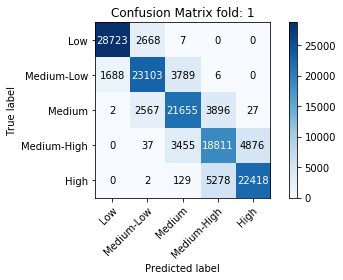

ACCURACY FOLD OBTAIN: 0.8014000654220581
PRECISION LOW:       0.9444316575148785
PRECISION MEDIUM-LOW: 0.8141452584839836
PRECISION MEDIUM:    0.7458240055105907
PRECISION MEDIUM-HIGH: 0.6720374406059091
PRECISION HIGH:      0.8205409758061565
RECALL LOW:          0.9148034906681954
RECALL MEDIUM-LOW:   0.808192821660953
RECALL MEDIUM:       0.7693537499555902
RECALL MEDIUM-HIGH:  0.6921152360278156
RECALL HIGH:         0.8056204405792935
FOLD NUMBER:             2


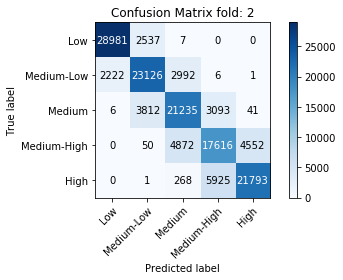

ACCURACY FOLD OBTAIN: 0.7877193689346313
PRECISION LOW:       0.9286103367618315
PRECISION MEDIUM-LOW: 0.7832418885050464
PRECISION MEDIUM:    0.7229182270034724
PRECISION MEDIUM-HIGH: 0.6612612612612613
PRECISION HIGH:      0.8258991169894266
RECALL LOW:          0.9193021411578113
RECALL MEDIUM-LOW:   0.815818252372385
RECALL MEDIUM:       0.7533614786958527
RECALL MEDIUM-HIGH:  0.6502768549280177
RECALL HIGH:         0.778682959945689
FOLD NUMBER:             3


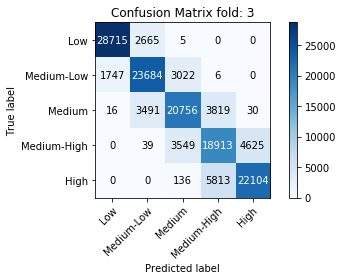

ACCURACY FOLD OBTAIN: 0.797652542591095
PRECISION LOW:       0.9421549970470503
PRECISION MEDIUM-LOW: 0.7926637437665249
PRECISION MEDIUM:    0.7556429299548566
PRECISION MEDIUM-HIGH: 0.6624286364750797
PRECISION HIGH:      0.8260398370641653
RECALL LOW:          0.9149275131432213
RECALL MEDIUM-LOW:   0.8322147651006712
RECALL MEDIUM:       0.7383323847467274
RECALL MEDIUM-HIGH:  0.6972277519722775
RECALL HIGH:         0.7879371190247032
ACCURACY OBTAIN:     0.7955906589825948
25     	 [6.49608446e-02 3.50809769e-01 5.56135463e-01 1.00000000e+00
 2.86000000e+02 2.23000000e+02 5.50000000e+01 2.00000000e+00]. 	  0.7955906589825948 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01087
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       298
TRY SECOND LAYER:      107

RUN NUMBER:             32
FOLD NUMBER:             1


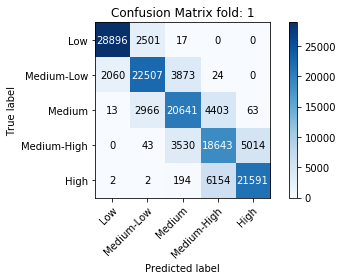

ACCURACY FOLD OBTAIN: 0.7844093441963196
PRECISION LOW:       0.9330018404313712
PRECISION MEDIUM-LOW: 0.8032763481922981
PRECISION MEDIUM:    0.7305255706954521
PRECISION MEDIUM-HIGH: 0.6379345743224747
PRECISION HIGH:      0.809622018899055
RECALL LOW:          0.919844655249252
RECALL MEDIUM-LOW:   0.7907181000562113
RECALL MEDIUM:       0.7349213131097344
RECALL MEDIUM-HIGH:  0.6846492838780757
RECALL HIGH:         0.7726800987725012
FOLD NUMBER:             2


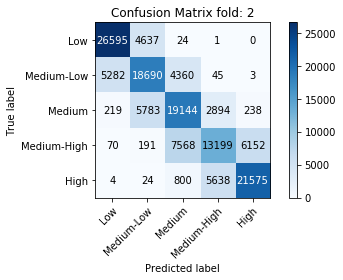

ACCURACY FOLD OBTAIN: 0.6930681467056274
PRECISION LOW:       0.826701896176562
PRECISION MEDIUM-LOW: 0.6373401534526855
PRECISION MEDIUM:    0.600200652119388
PRECISION MEDIUM-HIGH: 0.6060981769757083
PRECISION HIGH:      0.7714173340961098
RECALL LOW:          0.85084940973222
RECALL MEDIUM-LOW:   0.6585623678646935
RECALL MEDIUM:       0.6769927151849494
RECALL MEDIUM-HIGH:  0.48561442236938923
RECALL HIGH:         0.7694090795620698
FOLD NUMBER:             3


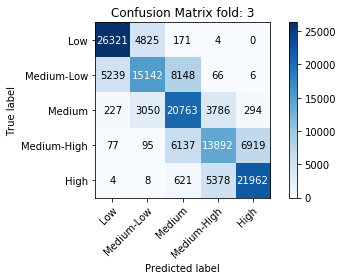

ACCURACY FOLD OBTAIN: 0.6852272152900696
PRECISION LOW:       0.8259382452617046
PRECISION MEDIUM-LOW: 0.6549307958477508
PRECISION MEDIUM:    0.5793247767857143
PRECISION MEDIUM-HIGH: 0.6007091585228747
PRECISION HIGH:      0.752613001610637
RECALL LOW:          0.8403626959547907
RECALL MEDIUM-LOW:   0.5294220481801336
RECALL MEDIUM:       0.738371266002845
RECALL MEDIUM-HIGH:  0.5122418879056048
RECALL HIGH:         0.7851142172809494
ACCURACY OBTAIN:     0.7209015687306722
26     	 [1.08731917e-02 2.35714463e-01 7.46000638e-01 2.00000000e+00
 2.98000000e+02 1.07000000e+02 6.40000000e+01 2.00000000e+00]. 	  0.7209015687306722 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01003
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       282

RUN NUMBER:             33
FOLD NUMBER:             1


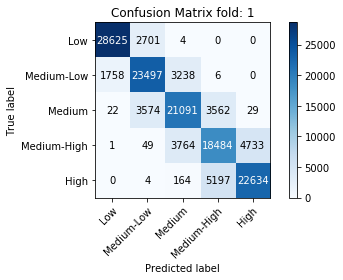

ACCURACY FOLD OBTAIN: 0.7987522482872009
PRECISION LOW:       0.9414260343353286
PRECISION MEDIUM-LOW: 0.7878290025146689
PRECISION MEDIUM:    0.7462934786454831
PRECISION MEDIUM-HIGH: 0.6783368196998055
PRECISION HIGH:      0.8261790042341948
RECALL LOW:          0.9136610277689116
RECALL MEDIUM-LOW:   0.8244850696515668
RECALL MEDIUM:       0.745844826366787
RECALL MEDIUM-HIGH:  0.6838074803003958
RECALL HIGH:         0.8083860137862067
FOLD NUMBER:             2


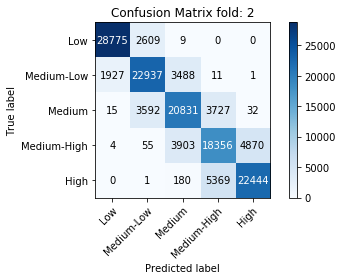

ACCURACY FOLD OBTAIN: 0.7918552756309509
PRECISION LOW:       0.936655707822011
PRECISION MEDIUM-LOW: 0.7856751387271357
PRECISION MEDIUM:    0.7332019288303826
PRECISION MEDIUM-HIGH: 0.6683901977205695
PRECISION HIGH:      0.8207115954218013
RECALL LOW:          0.9166056127162107
RECALL MEDIUM-LOW:   0.8086659145395572
RECALL MEDIUM:       0.7387665354470334
RECALL MEDIUM-HIGH:  0.6751508018243343
RECALL HIGH:         0.8017432306922913
FOLD NUMBER:             3


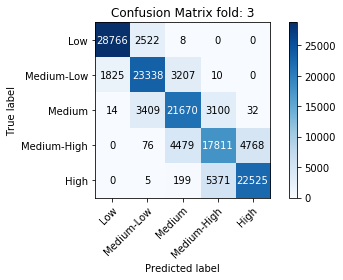

ACCURACY FOLD OBTAIN: 0.7972193956375122
PRECISION LOW:       0.9399117791210586
PRECISION MEDIUM-LOW: 0.7951618398637138
PRECISION MEDIUM:    0.7330108581673037
PRECISION MEDIUM-HIGH: 0.6774303970789594
PRECISION HIGH:      0.8243366880146387
RECALL LOW:          0.9191589979550102
RECALL MEDIUM-LOW:   0.8223396758280479
RECALL MEDIUM:       0.7677590788308237
RECALL MEDIUM-HIGH:  0.6564089334414388
RECALL HIGH:         0.8016014234875445
ACCURACY OBTAIN:     0.7959423065185547
27     	 [1.00349918e-02 7.62551871e-01 8.91760747e-01 1.00000000e+00
 2.82000000e+02 1.05000000e+02 6.30000000e+01 2.00000000e+00]. 	  0.7959423065185547 	 0.8027679920196533


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.02853
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       229

RUN NUMBER:             34
FOLD NUMBER:             1


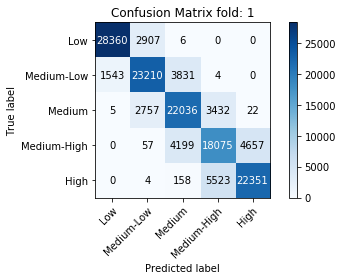

ACCURACY FOLD OBTAIN: 0.7966633439064026
PRECISION LOW:       0.9482412732379296
PRECISION MEDIUM-LOW: 0.8021427337134958
PRECISION MEDIUM:    0.7289447568640424
PRECISION MEDIUM-HIGH: 0.6686025005548568
PRECISION HIGH:      0.8268960414354422
RECALL LOW:          0.9068525565184025
RECALL MEDIUM-LOW:   0.8118791101161327
RECALL MEDIUM:       0.77998017839445
RECALL MEDIUM-HIGH:  0.6697421076033793
RECALL HIGH:         0.7972249964331574
FOLD NUMBER:             2


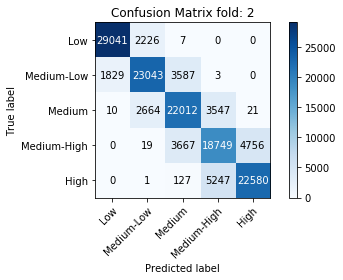

ACCURACY FOLD OBTAIN: 0.8064008951187134
PRECISION LOW:       0.9404468911917099
PRECISION MEDIUM-LOW: 0.8243480127356634
PRECISION MEDIUM:    0.7487074829931972
PRECISION MEDIUM-HIGH: 0.6806432875916648
PRECISION HIGH:      0.8253829001718025
RECALL LOW:          0.9285988360938799
RECALL MEDIUM-LOW:   0.8096057901763756
RECALL MEDIUM:       0.779075529128619
RECALL MEDIUM-HIGH:  0.6895296237725718
RECALL HIGH:         0.8077267036308353
FOLD NUMBER:             3


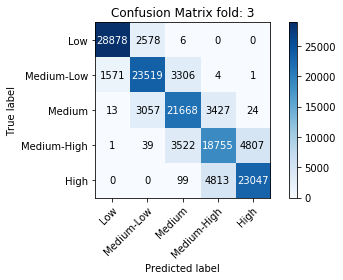

ACCURACY FOLD OBTAIN: 0.8094945549964905
PRECISION LOW:       0.947969668121984
PRECISION MEDIUM-LOW: 0.8056383379577295
PRECISION MEDIUM:    0.7575958882556554
PRECISION MEDIUM-HIGH: 0.6946553576058373
PRECISION HIGH:      0.8266795796118943
RECALL LOW:          0.9178691755133177
RECALL MEDIUM-LOW:   0.8281046442026689
RECALL MEDIUM:       0.7686686296072937
RECALL MEDIUM-HIGH:  0.6914540628225926
RECALL HIGH:         0.8243141743266926
ACCURACY OBTAIN:     0.8041862646738688
28     	 [2.85340171e-02 3.90342638e-01 1.08527796e-01 1.00000000e+00
 2.29000000e+02 1.02000000e+02 5.50000000e+01 2.00000000e+00]. 	  0.8041862646738688 	 0.8041862646738688


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01562
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       187
TRY SECOND LAYER:      180

RUN NUMBER:             35
FOLD NUMBER:             1


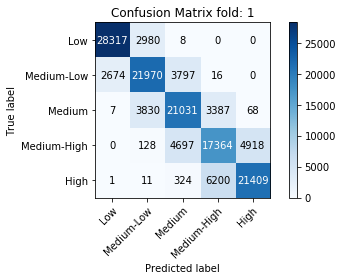

ACCURACY FOLD OBTAIN: 0.769130289554596
PRECISION LOW:       0.9134810800348399
PRECISION MEDIUM-LOW: 0.7597081503509803
PRECISION MEDIUM:    0.704390930100144
PRECISION MEDIUM-HIGH: 0.643898097674936
PRECISION HIGH:      0.8111005872324304
RECALL LOW:          0.9045519885002395
RECALL MEDIUM-LOW:   0.7720420283234354
RECALL MEDIUM:       0.742541397450835
RECALL MEDIUM-HIGH:  0.6405725458368687
RECALL HIGH:         0.7661120057255323
FOLD NUMBER:             2


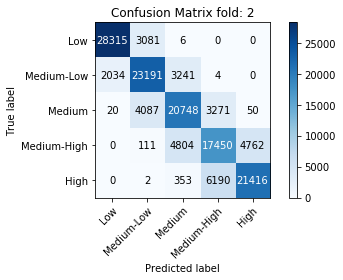

ACCURACY FOLD OBTAIN: 0.7763246297836304
PRECISION LOW:       0.9323652408706247
PRECISION MEDIUM-LOW: 0.7610593331583093
PRECISION MEDIUM:    0.7117178924259056
PRECISION MEDIUM-HIGH: 0.6483373583503622
PRECISION HIGH:      0.8165319505871588
RECALL LOW:          0.9016941596076683
RECALL MEDIUM-LOW:   0.8145767474534598
RECALL MEDIUM:       0.7363713798977853
RECALL MEDIUM-HIGH:  0.6432705422641648
RECALL HIGH:         0.7659239655234076
FOLD NUMBER:             3


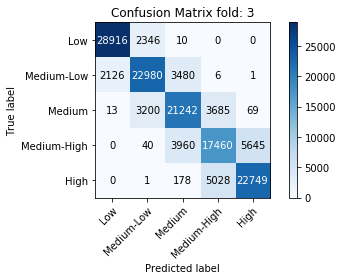

ACCURACY FOLD OBTAIN: 0.7918887734413147
PRECISION LOW:       0.9311222025438738
PRECISION MEDIUM-LOW: 0.8044246858263031
PRECISION MEDIUM:    0.7357810876342223
PRECISION MEDIUM-HIGH: 0.6669467894113602
PRECISION HIGH:      0.7992200674536256
RECALL LOW:          0.9246610386288053
RECALL MEDIUM-LOW:   0.803693211625223
RECALL MEDIUM:       0.7530220851501294
RECALL MEDIUM-HIGH:  0.6441615938018815
RECALL HIGH:         0.8137430247531836
ACCURACY OBTAIN:     0.779114564259847
29     	 [1.56180233e-02 5.32320971e-01 4.16081023e-01 2.00000000e+00
 1.87000000e+02 1.80000000e+02 5.40000000e+01 2.00000000e+00]. 	  0.779114564259847 	 0.8041862646738688


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.07756
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       213

RUN NUMBER:             36
FOLD NUMBER:             1


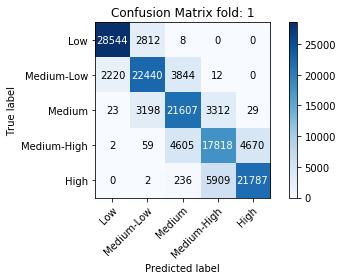

ACCURACY FOLD OBTAIN: 0.7838364839553833
PRECISION LOW:       0.9270843483062132
PRECISION MEDIUM-LOW: 0.7870646417172319
PRECISION MEDIUM:    0.7131023102310231
PRECISION MEDIUM-HIGH: 0.6586817492883812
PRECISION HIGH:      0.8225855168768406
RECALL LOW:          0.9100879989797219
RECALL MEDIUM-LOW:   0.7869266376770936
RECALL MEDIUM:       0.7670488835244418
RECALL MEDIUM-HIGH:  0.6561832510863961
RECALL HIGH:         0.7799455860241999
FOLD NUMBER:             2


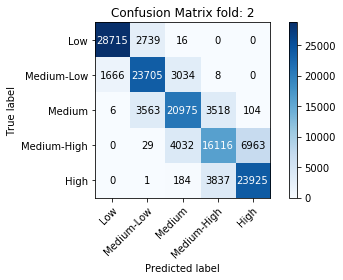

ACCURACY FOLD OBTAIN: 0.7925050258636475
PRECISION LOW:       0.9449764702010728
PRECISION MEDIUM-LOW: 0.7891933282285182
PRECISION MEDIUM:    0.7427144931128501
PRECISION MEDIUM-HIGH: 0.6864006133140254
PRECISION HIGH:      0.7719734124935467
RECALL LOW:          0.9124563075945344
RECALL MEDIUM-LOW:   0.8343012001548586
RECALL MEDIUM:       0.7446921820634808
RECALL MEDIUM-HIGH:  0.5938098747236551
RECALL HIGH:         0.8560847318137904
FOLD NUMBER:             3


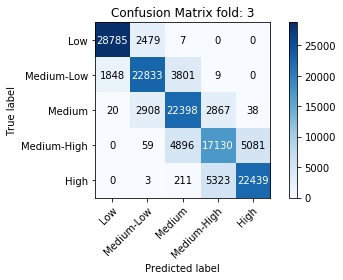

ACCURACY FOLD OBTAIN: 0.7935515642166138
PRECISION LOW:       0.9390597983884122
PRECISION MEDIUM-LOW: 0.8073332861890955
PRECISION MEDIUM:    0.7152939673617986
PRECISION MEDIUM-HIGH: 0.6762998934028189
PRECISION HIGH:      0.8142463168589883
RECALL LOW:          0.9205014230437146
RECALL MEDIUM-LOW:   0.8014109718858587
RECALL MEDIUM:       0.7933831603556374
RECALL MEDIUM-HIGH:  0.63056762129132
RECALL HIGH:         0.8020803545896482
ACCURACY OBTAIN:     0.7899643580118815
30     	 [7.75643366e-02 7.56842250e-01 1.49761550e-01 1.00000000e+00
 2.13000000e+02 2.48000000e+02 6.30000000e+01 2.00000000e+00]. 	  0.7899643580118815 	 0.8041862646738688


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
bo.run(max_iter=30, init_evals=1, resume=False)

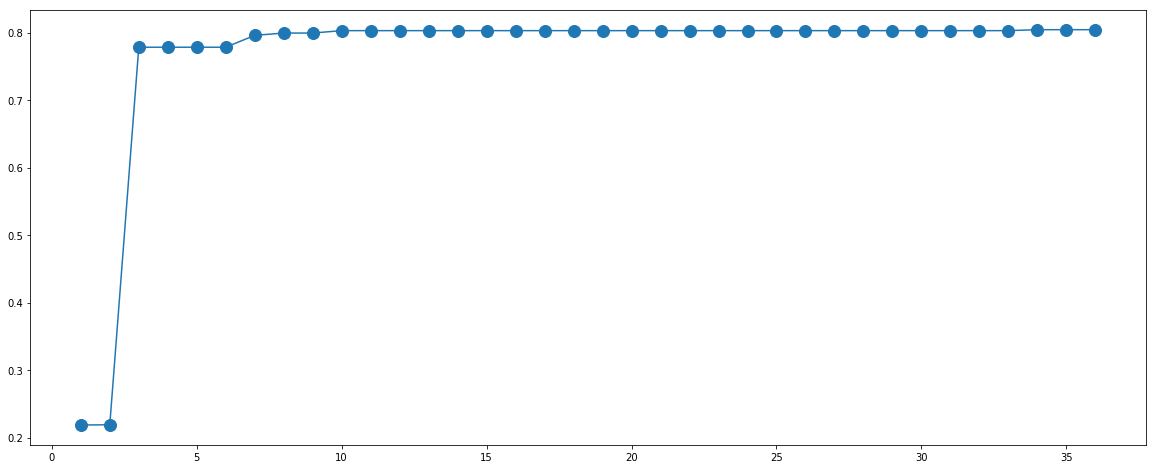

In [24]:
plt.figure(figsize=(20,8))
turn = list()
for i in range(36):
    turn.append(i+1)

plt.plot(turn, best_seen, 'o-', markersize=12, label='Best Seen')

# Performance Analysis

In [ ]:
bo.best